# Introduction

Healthcare delivery in many parts of the world faces a shortage of medical professionals and limited access to diagnostic tools. Patients often rely on self-reported symptoms, which may lead to misdiagnosis or delays in treatment.

Machine learning offers an opportunity to support medical decision-making by identifying disease patterns directly from symptom data.

This notebook presents a symptom-based disease prediction system developed for the hackathon challenge. Using a dataset of over 30,000 patient records, we apply machine learning models to predict common illnesses such as malaria, conjunctivitis, gastroenteritis, and others.
The goal is not to replace doctors, but to provide a decision-support tool that can:

1. Suggest the most likely disease given patient symptoms.

2. Provide alternative possibilities with confidence scores.

3. Help prioritize which cases require urgent medical review.

# Problem Statement

Early and accurate disease diagnosis is crucial for timely treatment, yet in many low-resource settings, this remains a major challenge.
The problem can be summarized as follows:

Input: Patient-reported symptoms (binary indicators: present/absent).

Output: Predicted disease (multiclass classification) with confidence scores.

Constraints:

Limited demographic information (most datasets lack consistent age, gender, BMI, etc.).

Class imbalance; some diseases are very common, while others are rare.

Overlap in symptom presentation (e.g., fever occurs in malaria, typhoid, and flu).

Our task is to build a robust and interpretable model that can handle these challenges, provide reliable predictions, and serve as a foundation for real-world healthcare decision support.

# Libraries
We begin by importing all required Python libraries for data processing, visualization, and modeling.


In [ ]:

# Core Libraries
import pandas as pd              # DataFrame manipulation and analysis
import numpy as np               # Numerical computing and array operations
import os                        # Interacting with the operating system (paths, files)
import warnings                  # Handling and suppressing warnings
warnings.filterwarnings("ignore")


# Visualization
import matplotlib.pyplot as plt  # Data visualization (plots, charts)
import seaborn as sns            # Statistical data visualization (heatmaps, distributions)

# Machine Learning Utilities
from sklearn.utils import resample                        # Bootstrap resampling
from sklearn.model_selection import train_test_split      # Train/validation splitting
from sklearn.preprocessing import LabelEncoder            # Encoding categorical labels
from sklearn.feature_selection import chi2                # Chi-square test for feature selection
from sklearn.metrics import (                             # Model evaluation metrics
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report
)

# ML Models
from sklearn.tree import DecisionTreeClassifier           # Decision Tree model
from sklearn.ensemble import RandomForestClassifier       # Random Forest model
from xgboost import XGBClassifier                         # XGBoost model
from lightgbm import LGBMClassifier                       # LightGBM model
from sklearn.model_selection import RandomizedSearchCV    # search for model parameters


# Dimensionality Reduction
import umap                                               # UMAP for visualization & embedding

# Statistics
from scipy.stats import randint, uniform                  # Random distributions for hyperparameter tuning
from statsmodels.stats.proportion import proportion_confint  # Confidence intervals for proportions


## Kaggle API Setup
Datasets are sourced directly from Kaggle using the Kaggle API for seamless integration.


In [ ]:
from google.colab import files
files.upload()   # pick the kaggle.json file from your computer

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adeteyeadedimeji","key":"acfd38e521d577b6e41ece78e834024c"}'}

In [ ]:
# 2. Move kaggle.json into the right place
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Dataset Overview
We worked with **6 datasets** containing symptoms for several common diseases.  
Each dataset is retrieved directly from Kaggle using a helper function that requires:

1. Kaggle dataset identifier (`username/dataset-name`)  
2. Local folder for download and extraction  
3. Filename of the target CSV  
4. (Optional) Index of the CSV file to load  

All datasets are later standardized and merged into a single working DataFrame.


In [ ]:
# A function used to load datasets from kaggle straight into a dataframe in google collaboratory
def load_kaggle_dataset(dataset_slug, extract_path="/content/kaggle_data",
                        file_name=None, file_index=None):
    """
    Download and load a Kaggle dataset as a Pandas DataFrame.

    Parameters:
        dataset_slug (str): e.g., "s3programmer/disease-diagnosis-dataset"
        extract_path (str): where to unzip the dataset
        file_name (str): optional, exact CSV filename inside the dataset
        file_index (int): optional, index of CSV file (0-based).
                          e.g., file_index=2 → third CSV.

    Returns:
        DataFrame (pd.DataFrame)
    """
    # This ensure extract path exists
    os.makedirs(extract_path, exist_ok=True)

    # This downloads the dataset
    zip_path = os.path.join(extract_path, dataset_slug.split("/")[-1] + ".zip")
    !kaggle datasets download -d {dataset_slug} -p {extract_path} --force

    # This unzips the dataset
    !unzip -o {zip_path} -d {extract_path}

    # This finds all CSV files
    csv_files = []
    for root, dirs, files in os.walk(extract_path):
        for f in files:
            if f.endswith(".csv"):
                csv_files.append(os.path.join(root, f))

    if not csv_files:
        raise ValueError(" No CSV files found in this dataset.")

    print(" Found CSV files:")
    for i, f in enumerate(csv_files):
        print(f"[{i}] {f}")

    # Case 1: Exact filename given
    if file_name:
        file_path = [f for f in csv_files if os.path.basename(f) == file_name]
        if not file_path:
            raise ValueError(f" File '{file_name}' not found. Available: {csv_files}")
        file_path = file_path[0]

    # Case 2: Index given
    elif file_index is not None:
        if file_index >= len(csv_files):
            raise IndexError(f" Index {file_index} out of range. Found {len(csv_files)} CSVs.")
        file_path = csv_files[file_index]

    # Case 3: Only one CSV → load automatically
    elif len(csv_files) == 1:
        file_path = csv_files[0]

    else:
        raise ValueError(" Multiple CSVs found. Please specify `file_name` or `file_index`.")

    print(f"\n Loading: {file_path}")
    return pd.read_csv(file_path)


In [ ]:
# load the first dataset
df_1 = load_kaggle_dataset(
    "itachi9604/disease-symptom-description-dataset",
    file_name='dataset.csv')
df_1.head()

Dataset URL: https://www.kaggle.com/datasets/itachi9604/disease-symptom-description-dataset
License(s): CC-BY-SA-4.0
  0% 0.00/30.1k [00:00<?, ?B/s]
100% 30.1k/30.1k [00:00<00:00, 132MB/s]
Archive:  /content/kaggle_data/disease-symptom-description-dataset.zip
  inflating: /content/kaggle_data/Symptom-severity.csv  
  inflating: /content/kaggle_data/dataset.csv  
  inflating: /content/kaggle_data/symptom_Description.csv  
  inflating: /content/kaggle_data/symptom_precaution.csv  
 Found CSV files:
[0] /content/kaggle_data/dataset.csv
[1] /content/kaggle_data/Symptom-severity.csv
[2] /content/kaggle_data/symptom_Description.csv
[3] /content/kaggle_data/symptom_precaution.csv

 Loading: /content/kaggle_data/dataset.csv


,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# load the second dataset
df_2 = load_kaggle_dataset(
    "s3programmer/disease-diagnosis-dataset",
    file_name="disease_diagnosis.csv")
df_2.head()

Dataset URL: https://www.kaggle.com/datasets/s3programmer/disease-diagnosis-dataset
License(s): CC0-1.0
  0% 0.00/32.8k [00:00<?, ?B/s]
100% 32.8k/32.8k [00:00<00:00, 133MB/s]
Archive:  /content/kaggle_data/disease-diagnosis-dataset.zip
  inflating: /content/kaggle_data/disease_diagnosis.csv  
 Found CSV files:
[0] /content/kaggle_data/dataset.csv
[1] /content/kaggle_data/Symptom-severity.csv
[2] /content/kaggle_data/disease_diagnosis.csv
[3] /content/kaggle_data/symptom_Description.csv
[4] /content/kaggle_data/symptom_precaution.csv

 Loading: /content/kaggle_data/disease_diagnosis.csv


,Patient_ID,Age,Gender,Symptom_1,Symptom_2,Symptom_3,Heart_Rate_bpm,Body_Temperature_C,Blood_Pressure_mmHg,Oxygen_Saturation_%,Diagnosis,Severity,Treatment_Plan
0,1,74,Male,Fatigue,Sore throat,Fever,69,39.4,132/91,94,Flu,Moderate,Medication and rest
1,2,66,Female,Sore throat,Fatigue,Cough,95,39.0,174/98,98,Healthy,Mild,Rest and fluids
2,3,32,Male,Body ache,Sore throat,Fatigue,77,36.8,136/60,96,Healthy,Mild,Rest and fluids
3,4,21,Female,Shortness of breath,Headache,Cough,72,38.9,147/82,99,Healthy,Mild,Rest and fluids
4,5,53,Male,Runny nose,Sore throat,Fatigue,100,36.6,109/106,92,Healthy,Mild,Rest and fluids


In [ ]:
# load the third dataset
df_3 = load_kaggle_dataset(
    "dhivyeshrk/diseases-and-symptoms-dataset",
    file_name="Final_Augmented_dataset_Diseases_and_Symptoms.csv")
df_3.head()

Dataset URL: https://www.kaggle.com/datasets/dhivyeshrk/diseases-and-symptoms-dataset
License(s): world-bank
  0% 0.00/2.81M [00:00<?, ?B/s]
100% 2.81M/2.81M [00:00<00:00, 789MB/s]
Archive:  /content/kaggle_data/diseases-and-symptoms-dataset.zip
  inflating: /content/kaggle_data/Final_Augmented_dataset_Diseases_and_Symptoms.csv  
 Found CSV files:
[0] /content/kaggle_data/dataset.csv
[1] /content/kaggle_data/Symptom-severity.csv
[2] /content/kaggle_data/disease_diagnosis.csv
[3] /content/kaggle_data/symptom_Description.csv
[4] /content/kaggle_data/symptom_precaution.csv
[5] /content/kaggle_data/Final_Augmented_dataset_Diseases_and_Symptoms.csv

 Loading: /content/kaggle_data/Final_Augmented_dataset_Diseases_and_Symptoms.csv


,diseases,anxiety and nervousness,depression,shortness of breath,depressive or psychotic symptoms,sharp chest pain,dizziness,insomnia,abnormal involuntary movements,chest tightness,...,stuttering or stammering,problems with orgasm,nose deformity,lump over jaw,sore in nose,hip weakness,back swelling,ankle stiffness or tightness,ankle weakness,neck weakness
0,panic disorder,1,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,panic disorder,0,0,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,panic disorder,1,1,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,panic disorder,1,0,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,panic disorder,1,1,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# load the fourth dataset
df_4 = load_kaggle_dataset(
    "uom190346a/disease-symptoms-and-patient-profile-dataset",
    file_name="Disease_symptom_and_patient_profile_dataset.csv")
df_4.head()

Dataset URL: https://www.kaggle.com/datasets/uom190346a/disease-symptoms-and-patient-profile-dataset
License(s): CC0-1.0
  0% 0.00/3.07k [00:00<?, ?B/s]
100% 3.07k/3.07k [00:00<00:00, 13.7MB/s]
Archive:  /content/kaggle_data/disease-symptoms-and-patient-profile-dataset.zip
  inflating: /content/kaggle_data/Disease_symptom_and_patient_profile_dataset.csv  
 Found CSV files:
[0] /content/kaggle_data/dataset.csv
[1] /content/kaggle_data/Symptom-severity.csv
[2] /content/kaggle_data/disease_diagnosis.csv
[3] /content/kaggle_data/symptom_Description.csv
[4] /content/kaggle_data/Disease_symptom_and_patient_profile_dataset.csv
[5] /content/kaggle_data/symptom_precaution.csv
[6] /content/kaggle_data/Final_Augmented_dataset_Diseases_and_Symptoms.csv

 Loading: /content/kaggle_data/Disease_symptom_and_patient_profile_dataset.csv


,Disease,Fever,Cough,Fatigue,Difficulty Breathing,Age,Gender,Blood Pressure,Cholesterol Level,Outcome Variable
0,Influenza,Yes,No,Yes,Yes,19,Female,Low,Normal,Positive
1,Common Cold,No,Yes,Yes,No,25,Female,Normal,Normal,Negative
2,Eczema,No,Yes,Yes,No,25,Female,Normal,Normal,Negative
3,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive
4,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive


In [ ]:
# load the fifth dataset
df_5 = load_kaggle_dataset(
    "behzadhassan/sympscan-symptomps-to-disease",
    file_name="Diseases_and_Symptoms_dataset.csv")
df_5.head()

Dataset URL: https://www.kaggle.com/datasets/behzadhassan/sympscan-symptomps-to-disease
License(s): CC0-1.0
  0% 0.00/1.08M [00:00<?, ?B/s]
100% 1.08M/1.08M [00:00<00:00, 774MB/s]
Archive:  /content/kaggle_data/sympscan-symptomps-to-disease.zip
  inflating: /content/kaggle_data/Diseases_and_Symptoms_dataset.csv  
  inflating: /content/kaggle_data/description.csv  
  inflating: /content/kaggle_data/diets.csv  
  inflating: /content/kaggle_data/medications.csv  
  inflating: /content/kaggle_data/precautions.csv  
  inflating: /content/kaggle_data/workout.csv  
 Found CSV files:
[0] /content/kaggle_data/dataset.csv
[1] /content/kaggle_data/Symptom-severity.csv
[2] /content/kaggle_data/description.csv
[3] /content/kaggle_data/precautions.csv
[4] /content/kaggle_data/disease_diagnosis.csv
[5] /content/kaggle_data/symptom_Description.csv
[6] /content/kaggle_data/Disease_symptom_and_patient_profile_dataset.csv
[7] /content/kaggle_data/Diseases_and_Symptoms_dataset.csv
[8] /content/kaggle_data

,diseases,anxiety and nervousness,depression,shortness of breath,depressive or psychotic symptoms,sharp chest pain,dizziness,insomnia,abnormal involuntary movements,chest tightness,...,sneezing,leg weakness,hysterical behavior,arm lump or mass,bleeding gums,pain in gums,diaper rash,hesitancy,back stiffness or tightness,low urine output
0,panic disorder,1,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,panic disorder,0,0,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,panic disorder,1,1,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,panic disorder,1,0,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,panic disorder,1,1,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# load the sixth dataset
df_6 = load_kaggle_dataset(
    "programmer3/malaria-diagnosis-dataset",
    file_name="Malaria_Dataset.csv")
df_6.head()

Dataset URL: https://www.kaggle.com/datasets/programmer3/malaria-diagnosis-dataset
License(s): CC0-1.0
  0% 0.00/42.5k [00:00<?, ?B/s]
100% 42.5k/42.5k [00:00<00:00, 129MB/s]
Archive:  /content/kaggle_data/malaria-diagnosis-dataset.zip
  inflating: /content/kaggle_data/Malaria_Dataset.csv  
 Found CSV files:
[0] /content/kaggle_data/dataset.csv
[1] /content/kaggle_data/Symptom-severity.csv
[2] /content/kaggle_data/description.csv
[3] /content/kaggle_data/precautions.csv
[4] /content/kaggle_data/disease_diagnosis.csv
[5] /content/kaggle_data/symptom_Description.csv
[6] /content/kaggle_data/Disease_symptom_and_patient_profile_dataset.csv
[7] /content/kaggle_data/Diseases_and_Symptoms_dataset.csv
[8] /content/kaggle_data/diets.csv
[9] /content/kaggle_data/symptom_precaution.csv
[10] /content/kaggle_data/Final_Augmented_dataset_Diseases_and_Symptoms.csv
[11] /content/kaggle_data/Malaria_Dataset.csv
[12] /content/kaggle_data/workout.csv
[13] /content/kaggle_data/medications.csv

 Loading: /

,IP_Number,Age,Sex,Residence_Area,DOA,Discharge_Date,Fever,Headache,Abdominal_Pain,General_Body_Malaise,...,Vomiting,Confusion,Backache,Chest_Pain,Coughing,Joint_Pain,Primary_Code,Diagnosis_Type,Target,Risk_Score
0,14xxxx31,52,Female,Mangalore,31-10-2015 20:42,05-11-2015 05:16,0,0,0,1,...,0,0,1,0,0,0,B50.9,Mixed Malaria Infection,0,3
1,28xxxx34,75,Female,Shimoga,03-02-2015 23:28,13-02-2015 19:27,1,0,1,1,...,0,1,0,1,1,1,B50.9,Mixed Malaria Infection,1,11
2,96xxxx43,30,Female,Mangalore,15-11-2019 12:31,19-11-2019 14:31,1,1,1,1,...,0,1,1,1,0,1,B50.9,Mixed Malaria Infection,1,13
3,49xxxx87,89,Female,Mangalore,17-05-2017 17:50,23-05-2017 13:22,0,0,0,0,...,1,1,1,1,0,1,B54,Plasmodium vivax Malaria without complication,0,5
4,48xxxx10,62,Male,Shimoga,26-06-2015 15:29,27-06-2015 23:35,0,1,0,1,...,1,1,0,0,0,0,B51.0,Plasmodium falciparum Malaria without complica...,1,8


### Note on Feature Selection and Data Limitations

In this project, the initial plan was to incorporate both **symptoms** and **demographic features** (e.g., age, gender, weight, BMI) for disease prediction. However, only **2 out of the 6 available datasets** contained demographic information, making it inconsistent and unreliable to use across the full dataset.  

To ensure **data uniformity and model comparability**, the final modeling pipeline was built using **symptoms only** as input features, with **disease type** as the prediction target.  

While this approach may seem limited from a **clinical perspective**—since demographics often play a critical role in medical diagnosis—it was a necessary trade-off to maximize dataset coverage and maintain methodological consistency. The decision ensures that results are based on the **largest, most complete subset of available data**, even if it comes at the expense of missing valuable demographic context.  


# Data Preprocessing
To prepare the datasets for merging, we applied the following steps:

1. Normalize column names (lowercase, remove underscores).  
2. Inspect dataset shapes and unique diseases.  
3. Apply consistent encoding across all datasets.  
4. Merge into a single DataFrame for modeling.  

Steps 1 & 2 were especially important to avoid mismatches across sources.


In [ ]:
# this allows pandas to show the total number of columns
pd.set_option("display.max_columns", None)

In [ ]:
# function to convert every string in a df to lower case

def dataframe_to_lower(df):
    """
    Converts all string values AND column names in a DataFrame to lowercase.
    """
    # lowercase column names
    df.columns = df.columns.str.lower().str.strip()

    # lowercase all string values inside the DataFrame
    return df.applymap(lambda s: s.lower().strip() if isinstance(s, str) else s)

In [ ]:
def clean_underscores(df):
    """
    Replaces underscores with spaces in both column names and string values.

    Parameters:
        df (pd.DataFrame): Input dataframe

    Returns:
        pd.DataFrame: Cleaned dataframe
    """
    df = df.copy()

    # Fix column names
    df.columns = df.columns.str.replace("_", " ", regex=False)

    # Fix string values inside cells
    df = df.applymap(lambda x: x.replace("_", " ") if isinstance(x, str) else x)

    return df

### Preprocessing Each Dataset
Each of the 6 datasets underwent the same preprocessing pipeline:  
- Normalize column names  
- Encode binary symptom values  
- Remove redundant/empty columns  
- Standardize disease names  


In [ ]:
# converts all the string in a dataframe to lower case
df_1 = dataframe_to_lower(df_1)
df_2 = dataframe_to_lower(df_2)
df_3 = dataframe_to_lower(df_3)
df_4 = dataframe_to_lower(df_4)
df_5 = dataframe_to_lower(df_5)
df_6 = dataframe_to_lower(df_6)

In [ ]:
# removes all instances of underscore between strings in the dataframe
df_1= clean_underscores(df_1)
df_2= clean_underscores(df_2)
df_3= clean_underscores(df_3)
df_4= clean_underscores(df_4)
df_5= clean_underscores(df_5)
df_6= clean_underscores(df_6)

In [ ]:
# confirm the shape of each of the dataset
print('df_1: ', df_1.shape)
print('df_2: ', df_2.shape)
print('df_3: ', df_3.shape)
print('df_4: ', df_4.shape)
print('df_5: ', df_5.shape)
print('df_6: ', df_6.shape)

df_1:  (4920, 18)
df_2:  (2000, 13)
df_3:  (246945, 378)
df_4:  (349, 10)
df_5:  (96088, 231)
df_6:  (1622, 21)


#### More Preprocessing

These are cases whereby specific preprocessing had to be done to each some dataset to make it ready for combining

In [ ]:
# this renames the 'diagonis' column to 'disease' so as to match the same format of other dataset
df_2.rename(columns={'diagnosis': 'disease'}, inplace=True)

# drop columns that are not needed for the scope of the project
df_2 = df_2.drop(columns=['patient id', 'age', 'gender', 'heart rate bpm', 'body temperature c', 'blood pressure mmhg', 'oxygen saturation %', 'severity', 'treatment plan'])

# this filters the dataframe to keep values that don't count as 'healthy'
df_2 = df_2[df_2['disease'] != 'healthy']

In [ ]:
# this renames some columns(symptoms) to match the same format in other dataset
df_3.rename(columns={'diseases': 'disease'}, inplace=True)

# this renames some columns(symptoms) to match the same format in other dataset
df_3.rename(columns={"difficulty breathing": "shortness of breath",
                     "sharp chest pain": "chest pain",
                     "sharp abdominal pain": "abdominal pain",
                     "skin dryness, peeling, scaliness, or roughness": "skin dryness",
                     "abnormal appearing skin": "skin changes"}, inplace=True)

In [ ]:
# Keep only rows where Outcome Variable == 'Positive'
df_4 = df_4[df_4['outcome variable'] == 'positive']

# this renames some columns(symptoms) to match the same format in other datasets
df_4.rename(columns={"difficulty breathing": "shortness of breath",
                     "sharp chest pain": "chest pain",
                     "sharp abdominal pain": "abdominal pain",
                     "skin dryness, peeling, scaliness, or roughness": "skin dryness",
                     "abnormal appearing skin": "skin changes"}, inplace=True)

# drop columns that are not needed for the scope of the project
df_4 = df_4.drop(columns=['age', 'gender', 'blood pressure', 'cholesterol level', 'outcome variable'], axis=1)

# Map Yes -> 1 and No -> 0 for all symptom columns
df_4.iloc[:, 1:] = df_4.iloc[:, 1:].replace({'yes': 1, 'no': 0})

In [ ]:
# this renames some columns(symptoms) to match the same format in other dataset
df_5.rename(columns={'diseases': 'disease'}, inplace=True)

# this renames some columns(symptoms) to match the same format in other dataset
df_5.rename(columns={"difficulty breathing": "shortness of breath",
                     "sharp chest pain": "chest pain",
                     "sharp abdominal pain": "abdominal pain",
                     "skin dryness, peeling, scaliness, or roughness": "skin dryness",
                     "abnormal appearing skin": "skin changes"}, inplace=True)

In [ ]:
# drop columns that are not needed for the scope of the project
df_6 = df_6.drop(columns=['ip number', 'age', 'sex', 'residence area', 'doa', 'discharge date', 'primary code', 'diagnosis type', 'risk score'], axis=1)

# Filter rows where 'target' column is 1
df_6 = df_6[df_6['target'] == 1]

# drop the target column as it is no longer useful
df_6 = df_6.drop(columns=['target'], axis=1)

# Add a new column called 'disease' and fill it with 'malaria' since these are confirmed instances
df_6['disease'] = 'malaria'

# rename 'coughing' column to match the same column in other dataset
df_6.rename(columns={'coughing': 'cough'}, inplace=True)

# Move 'disease' column to the first position in df_6
cols = df_6.columns.tolist()
if "disease" in cols:
    cols.insert(0, cols.pop(cols.index("disease")))
    df_6 = df_6[cols]

In [ ]:
# Define mapping dictionary based on diseases that are subsets to other diseases(superset)
RENAME_MAP = {
    "flu": "influenza",

    "cold": "common cold",

    "allergy to animal": "allergy",
    "food allergy": "allergy",

    "conjunctivitis due to allergy": "conjunctivitis",
    "conjunctivitis due to bacteria": "conjunctivitis",
    "conjunctivitis due to virus": "conjunctivitis",

    "acute otitis media": "otitis media",
    "chronic otitis media": "otitis media",

    "infectious gastroenteritis": "gastroenteritis",
    "noninfectious gastroenteritis": "gastroenteritis",

    "fungal infection of the hair": "fungal infection",
    "fungal infection of the skin": "fungal infection",

    "chronic kidney disease": "kidney disease",
    "diabetic kidney disease": "kidney disease",
    "polycystic kidney disease": "kidney disease",
    "primary kidney disease": "kidney disease",

    "hypertension of pregnancy": "hypertension",
    "maligant hypertension": "hypertension",
    "pulmonary hypertension": "hypertension",

    "hypertensive heart disease": "heart disease",
    "ischemic heart disease": "heart disease",

    "diabetes insipidus": "diabetes",
    "gestational diabetes": "diabetes",

    "polycystic ovarian syndrome": "polycystic ovary syndrome",

    "reactive arthritis": "arthritis",
    "septic arthritis": "arthritis",
    "rheumatoid arthritis": "arthritis",

    "concussion": "head injury",
    "open wound to the head": "head injury",

    "postpartum depression": "depression",

    "anxiety disorder": "mental disorder",
    "panic disorder": "mental disorder",
    "bipolar disorder": "mental disorder",
}

In [ ]:
# function to rename diseases and symptoms to their parent group and common name (i.e groups that are the superset)
def rename_conditions(df, column):
    """
    Rename values in a dataframe column based on predefined mapping.

    Parameters:
        df (pd.DataFrame): The dataframe
        column (str): Column to apply renaming on

    Returns:
        pd.DataFrame: Copy of dataframe with renamed column
    """
    df = df.copy()
    df[column] = df[column].replace(RENAME_MAP)
    return df

In [ ]:
# applying the function to every dataframes
df_1 = rename_conditions(df_1, 'disease')
df_2 = rename_conditions(df_2, 'disease')
df_3 = rename_conditions(df_3, 'disease')
df_4 = rename_conditions(df_4, 'disease')
df_5 = rename_conditions(df_5, 'disease')
df_6 = rename_conditions(df_6, 'disease')

In [ ]:
# Define the diseases to keep (final list)
ALLOWED_CONDITIONS = {
    "common cold",
    "influenza",
    "allergy",
    "acute bronchitis",
    "pneumonia",
    "tuberculosis",
    "strep throat",
    "tonsillitis",
    "acute sinusitis",
    "conjunctivitis",
    "otitis media",
    "gastroenteritis",
    "chronic obstructive pulmonary disease",
    "appendicitis",
    "cholecystitis",
    "hemorrhoids",
    "fungal infection",
    "psoriasis",
    "eczema",
    "acne",
    "contact dermatitis",
    "tooth disorders",
    "gum disease",
    "urinary tract infection",
    "kidney disease",
    "hypertension",
    "heart disease",
    "heart failure",
    "heart attack",
    "diabetes",
    "polycystic ovary syndrome",
    "arthritis",
    "bursitis",
    "head injury",
    "migraine",
    "depression",
    "mental disorder",
    "cataract",
    "malaria"
}

In [ ]:
# function to filter the dataaset by the selected diseasedef filter_conditions(df, column, name="dataset"):
def filter_conditions(df, column, name="dataset"):
    """
    Filters dataset to only keep allowed conditions and prints shape.

    Parameters:
        df (pd.DataFrame): Input dataframe
        column (str): Column containing conditions
        name (str): Name of dataset (for logging)

    Returns:
        pd.DataFrame: Filtered dataframe
    """
    filtered = df[df[column].isin(ALLOWED_CONDITIONS)].copy()
    print(f"{name}: {df.shape} -> {filtered.shape}")
    return filtered

In [ ]:
# using the 'filterd_condition' function on all the datasets
filtered_dfs = []
for i, df in enumerate([df_1, df_2, df_3, df_4, df_5, df_6], start=1):
    filtered = filter_conditions(df, "disease", name=f"df_{i}")
    filtered_dfs.append(filtered)

# Now access them:
df_1_filtered, df_2_filtered, df_3_filtered, df_4_filtered, df_5_filtered, df_6_filtered = filtered_dfs

df_1: (4920, 18) -> (1800, 18)
df_2: (833, 4) -> (499, 4)
df_3: (246945, 378) -> (37332, 378)
df_4: (186, 5) -> (56, 5)
df_5: (96088, 231) -> (26325, 231)
df_6: (1167, 12) -> (1167, 12)


#### Additional Preprocessing
After initial cleaning, we:  
1. Converted datasets to binary (symptom present/absent).
2. Dropped empty rows
3. Dropped irrelevant or empty columns.  
4. Combined datasets into one unified DataFrame.  
5. Removed duplicates for a clean base dataset.  


In [ ]:
# a function that converts a disease–symptom dataset into a structured binary
def expand_symptoms(df, disease_col="disease"):
    """
    Transforms a DataFrame containing disease and symptom data into a binary format.

    This function identifies all unique symptoms across the specified symptom columns
    and creates a new DataFrame where each symptom is represented as a binary column.
    Each row indicates the presence (1) or absence (0) of a symptom for a given disease.

    Parameters:
    ----------
    df : pandas.DataFrame
        The input DataFrame containing disease and symptom information.
    disease_col : str, optional
        The name of the column representing the disease label (default is "disease").

    Returns:
    -------
    pandas.DataFrame
        A transformed DataFrame with the original disease column and binary symptom columns.
    """
    # Get all unique symptoms across all symptom columns
    symptom_cols = [col for col in df.columns if col != disease_col]
    unique_symptoms = pd.unique(df[symptom_cols].values.ravel())

    # Initialize new DataFrame with disease column
    result = pd.DataFrame({disease_col: df[disease_col]})

    # For each unique symptom, create a binary column
    for symptom in unique_symptoms:
        result[symptom] = df[symptom_cols].apply(lambda row: int(symptom in row.values), axis=1)

    return result

In [ ]:
# using it on the applicable datasets
df_1_filtered = expand_symptoms(df_1_filtered)
df_2_filtered = expand_symptoms(df_2_filtered)

In [ ]:
# a function that drops all row and columns that the values are all zeros (0)
def drop_all_zero(df):
    """
    Removes:
    1. Columns that contain only 0 values
    2. Rows that contain only 0 values
    """
    df = df.copy()

    # Step 1: Drop columns with all zeros
    df = df.loc[:, (df != 0).any(axis=0)]

    # Step 2: Drop rows with all zeros
    df = df.loc[(df != 0).any(axis=1)]

    return df

In [ ]:
# using the helper function on the datasets
datasets = [df_1_filtered, df_2_filtered, df_3_filtered, df_4_filtered, df_5_filtered, df_6_filtered]
cleaned_datasets = [drop_all_zero(df) for df in datasets]

df1_clean, df2_clean, df3_clean, df4_clean, df5_clean, df6_clean = cleaned_datasets


In [ ]:
# datasets to consider: df1_clean, df2_clean, df3_clean, df5_clean, df6_clean
dfs = [df1_clean, df2_clean, df3_clean, df5_clean, df6_clean]

# Ensure all column names are unique before concatenation
for i in range(len(dfs)):
    cols = dfs[i].columns.tolist()
    # Add a suffix to duplicate column names, except for 'disease'
    seen = {}
    new_cols = []
    for col in cols:
        if col != 'disease' and col in seen:
            seen[col] += 1
            new_cols.append(f"{col}_{seen[col]}")
        else:
            seen[col] = 0
            new_cols.append(col)
    dfs[i].columns = new_cols


# Align all symptom columns and stack them
combined_df = pd.concat(dfs, axis=0, ignore_index=True).fillna(0)

# Drop the duplicate 'shortness of breath_1' column
if 'shortness of breath_1' in combined_df.columns:
    combined_df = combined_df.drop(columns=['shortness of breath_1'])

# Remove duplicate rows (same disease + same symptom pattern)
combined_df = combined_df.drop_duplicates()

# view the first five rows of the dataframe
print(combined_df.head())

# confirm the shape of the combined dataframe
print(combined_df.shape)

            disease  itching  skin rash  nodal skin eruptions  \
0  fungal infection      1.0        1.0                   1.0   
1  fungal infection      0.0        1.0                   1.0   
2  fungal infection      1.0        0.0                   1.0   
3  fungal infection      1.0        1.0                   0.0   
4  fungal infection      1.0        1.0                   1.0   

   dischromic  patches  continuous sneezing  shivering  chills  \
0                  1.0                  0.0        0.0     0.0   
1                  1.0                  0.0        0.0     0.0   
2                  1.0                  0.0        0.0     0.0   
3                  1.0                  0.0        0.0     0.0   
4                  0.0                  0.0        0.0     0.0   

   watering from eyes  fatigue  weight loss  restlessness  lethargy  \
0                 0.0      0.0          0.0           0.0       0.0   
1                 0.0      0.0          0.0           0.0       0.0   

In [ ]:
# Check missing values per column
missing_summary = combined_df.isnull().sum().sort_values(ascending=False)

# Show only columns with missing values
missing_summary = missing_summary[missing_summary > 0]

print("Total missing values:", combined_df.isnull().sum().sum())
missing_summary.head(20)  # Show top 20

Total missing values: 0


,0


#### Summary
At this stage, each indiviual dataset has been cleaned throughly and merged into a single dataset

# Exploratory Data Analysis (EDA)
In this section, we explore disease distributions, symptom frequencies, and correlations.  
Visualizations (bar plots, heatmaps) help us understand data patterns before modeling.


### 1. Data basic structure

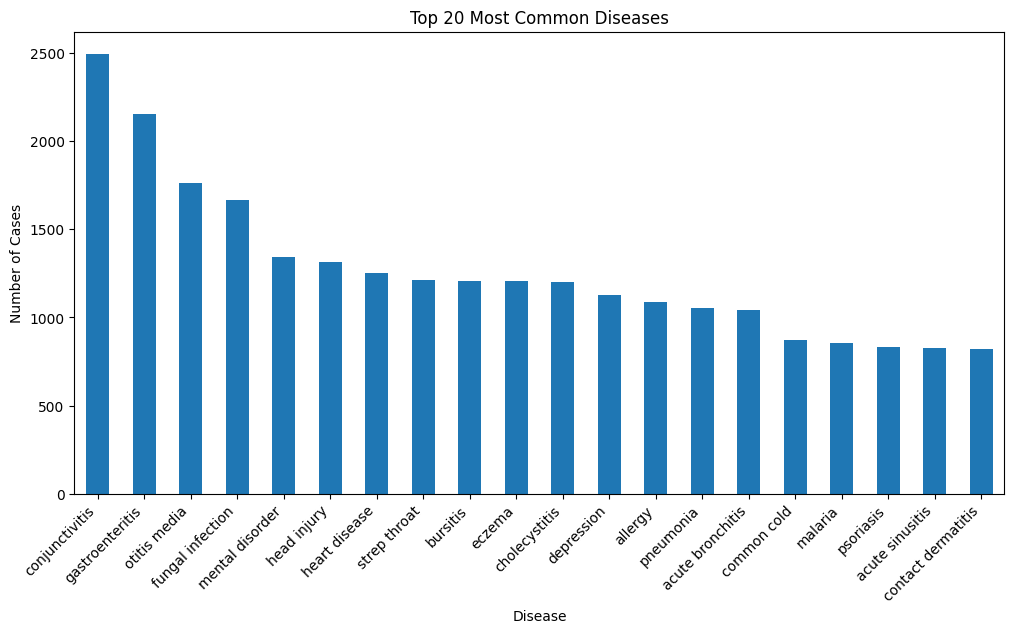

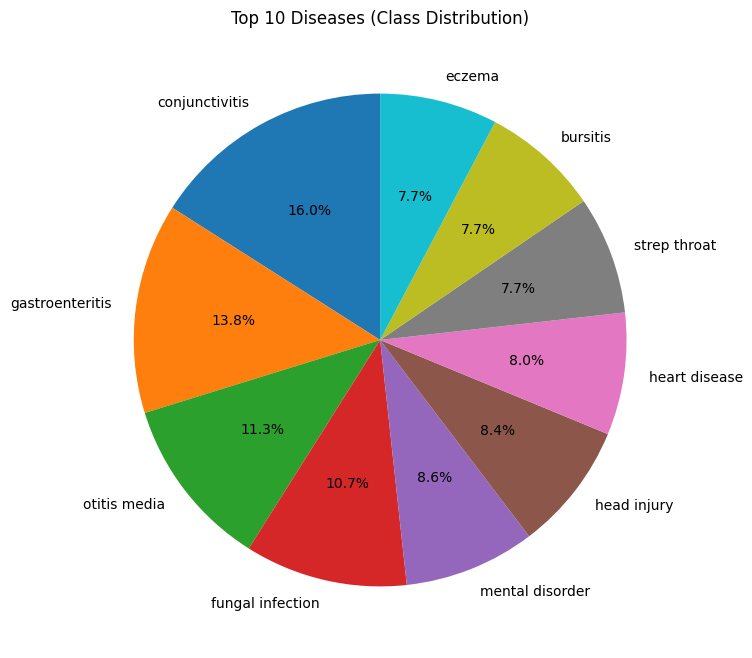

In [ ]:
# Disease counts
disease_counts = combined_df['disease'].value_counts()
disease_percent = combined_df['disease'].value_counts(normalize=True) * 100

# Plot top 20 diseases
plt.figure(figsize=(12,6))
disease_counts.head(20).plot(kind='bar')
plt.title("Top 20 Most Common Diseases")
plt.ylabel("Number of Cases")
plt.xlabel("Disease")
plt.xticks(rotation=45, ha="right")
plt.show()

# Plot distribution percentage (pie chart for top 10)
plt.figure(figsize=(8,8))
disease_percent.head(10).plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title("Top 10 Diseases (Class Distribution)")
plt.ylabel("")
plt.show()

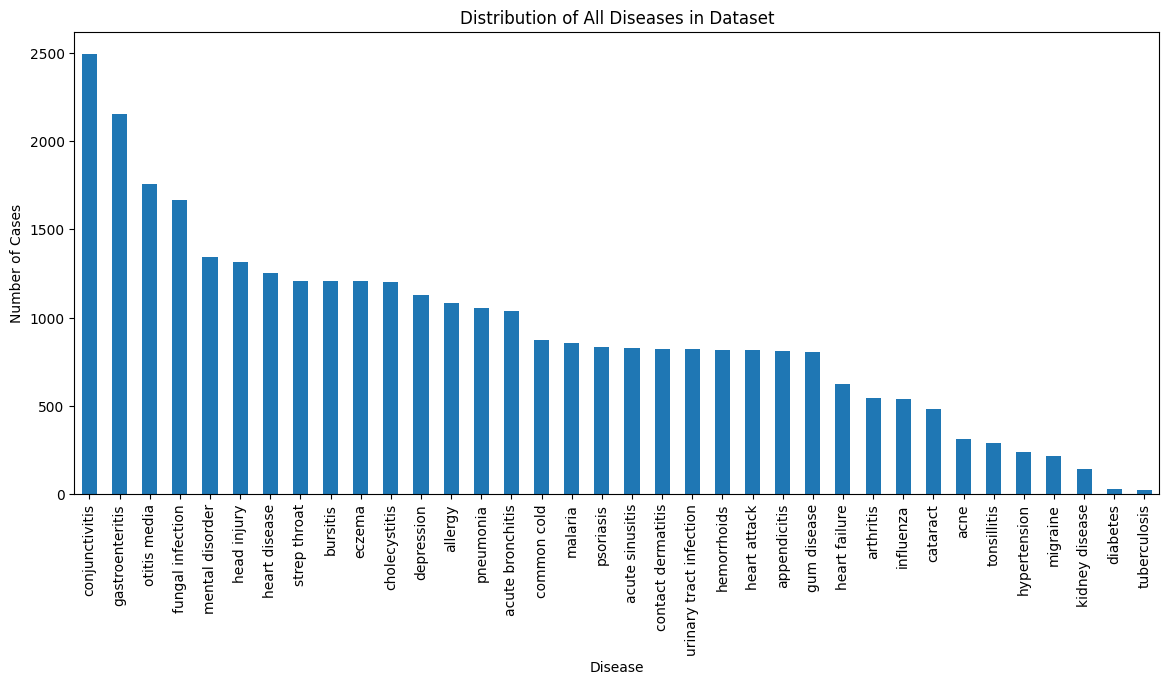

Most common disease count: 2496
Least common disease count: 19
Imbalance ratio (max/min): 131.37


In [ ]:
# Count number of cases per disease
disease_counts = combined_df['disease'].value_counts()

# Plot all diseases
plt.figure(figsize=(14, 6))
disease_counts.plot(kind='bar')

plt.title("Distribution of All Diseases in Dataset")
plt.xlabel("Disease")
plt.ylabel("Number of Cases")
plt.xticks(rotation=90)
plt.show()

# Also show imbalance ratio
print("Most common disease count:", disease_counts.max())
print("Least common disease count:", disease_counts.min())
print("Imbalance ratio (max/min):", round(disease_counts.max() / disease_counts.min(), 2))

### 2. Symptoms Relationship

####2.1 Symptom Frequency

Top 20 symptoms:
 fever                  7142.0
cough                  7029.0
vomiting               6248.0
nasal congestion       4939.0
headache               4336.0
sore throat            4205.0
nausea                 3982.0
skin rash              3690.0
chest pain             3540.0
coryza                 3286.0
abdominal pain         3033.0
chills                 3001.0
skin changes           2982.0
skin swelling          2914.0
shortness of breath    2880.0
itching of skin        2856.0
ear pain               2819.0
allergic reaction      2479.0
skin dryness           2421.0
skin lesion            2287.0
dtype: float64


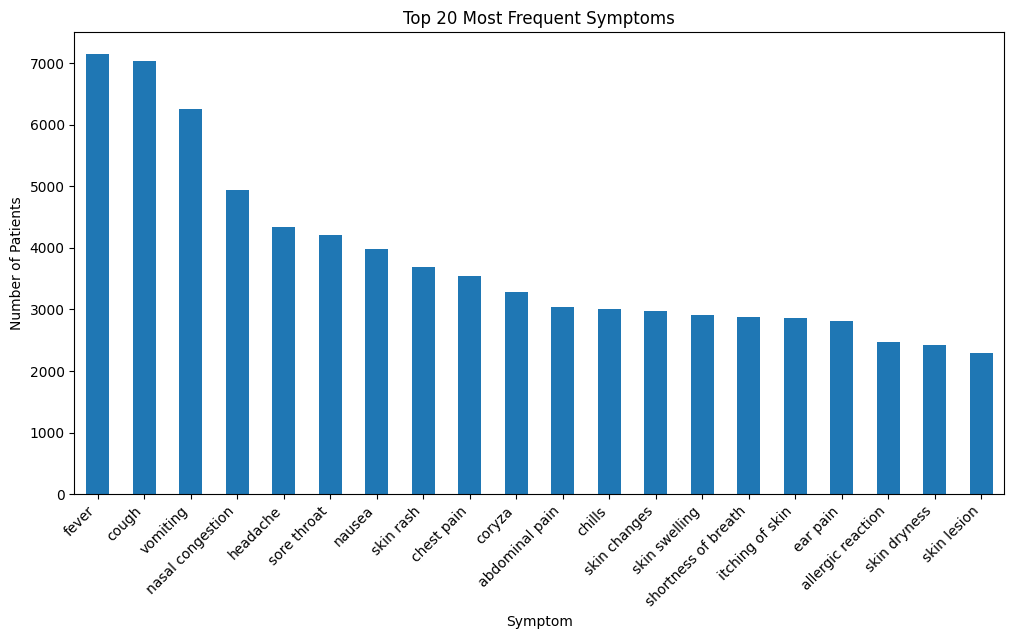

In [ ]:
# Drop target column
symptom_df = combined_df.drop(columns="disease")

# Count how many patients had each symptom
symptom_counts = symptom_df.sum().sort_values(ascending=False)

# Show top 20 most frequent symptoms
print("Top 20 symptoms:\n", symptom_counts.head(20))

# Plot
plt.figure(figsize=(12,6))
symptom_counts.head(20).plot(kind="bar")
plt.title("Top 20 Most Frequent Symptoms")
plt.ylabel("Number of Patients")
plt.xlabel("Symptom")
plt.xticks(rotation=45, ha="right")
plt.show()

#### 2.2 Symptom–Disease Relationship (Crosstab)

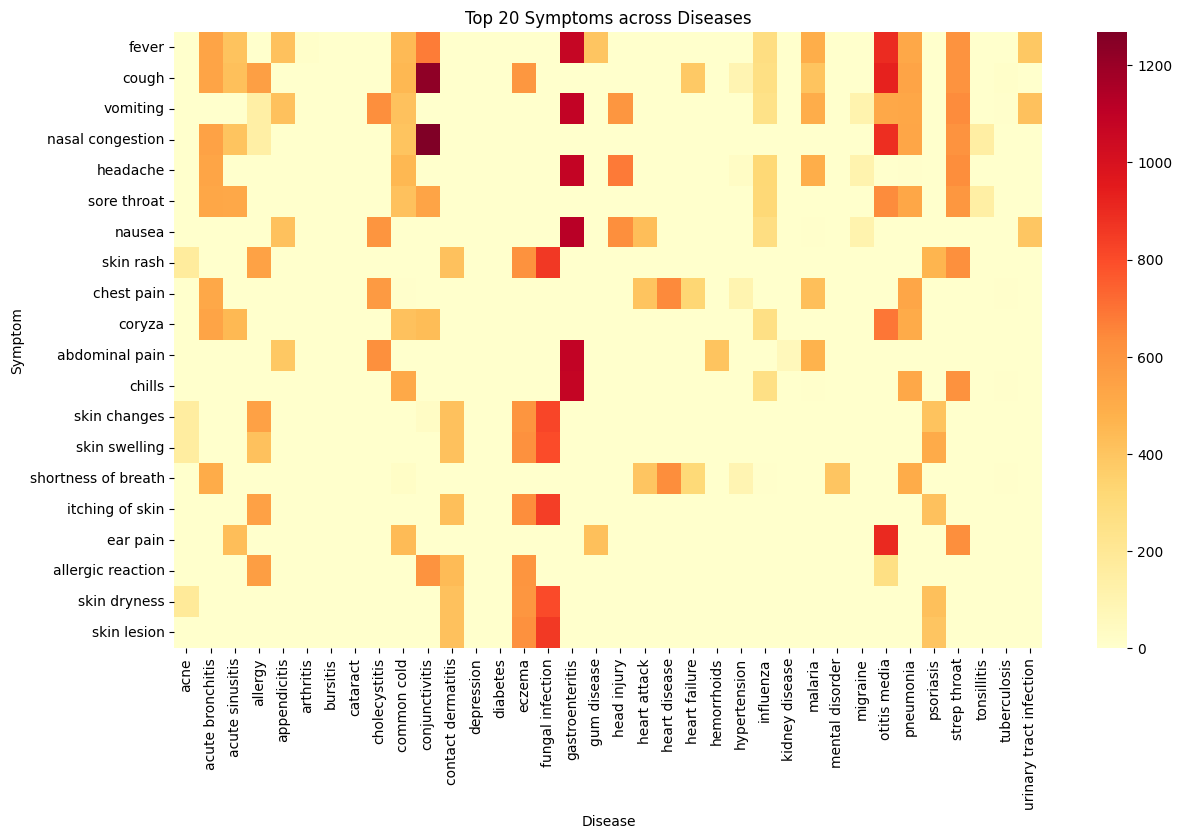

In [ ]:
# Pick top 20 symptoms
top20_symptoms = symptom_counts.head(20).index

# Aggregate: sum of symptom presence per disease
symptom_disease_matrix = combined_df.groupby('disease')[top20_symptoms].sum()

# Plot heatmap
plt.figure(figsize=(14,8))
sns.heatmap(symptom_disease_matrix.T, cmap="YlOrRd", cbar=True)
plt.title("Top 20 Symptoms across Diseases")
plt.xlabel("Disease")
plt.ylabel("Symptom")
plt.show()

NOTE: this visualization is good but it is not the most effective in the sense that some diseases, their symptoms are not in the top 20 symptoms in the dataset.

#### 2.3 Symptom–Symptom Correlation

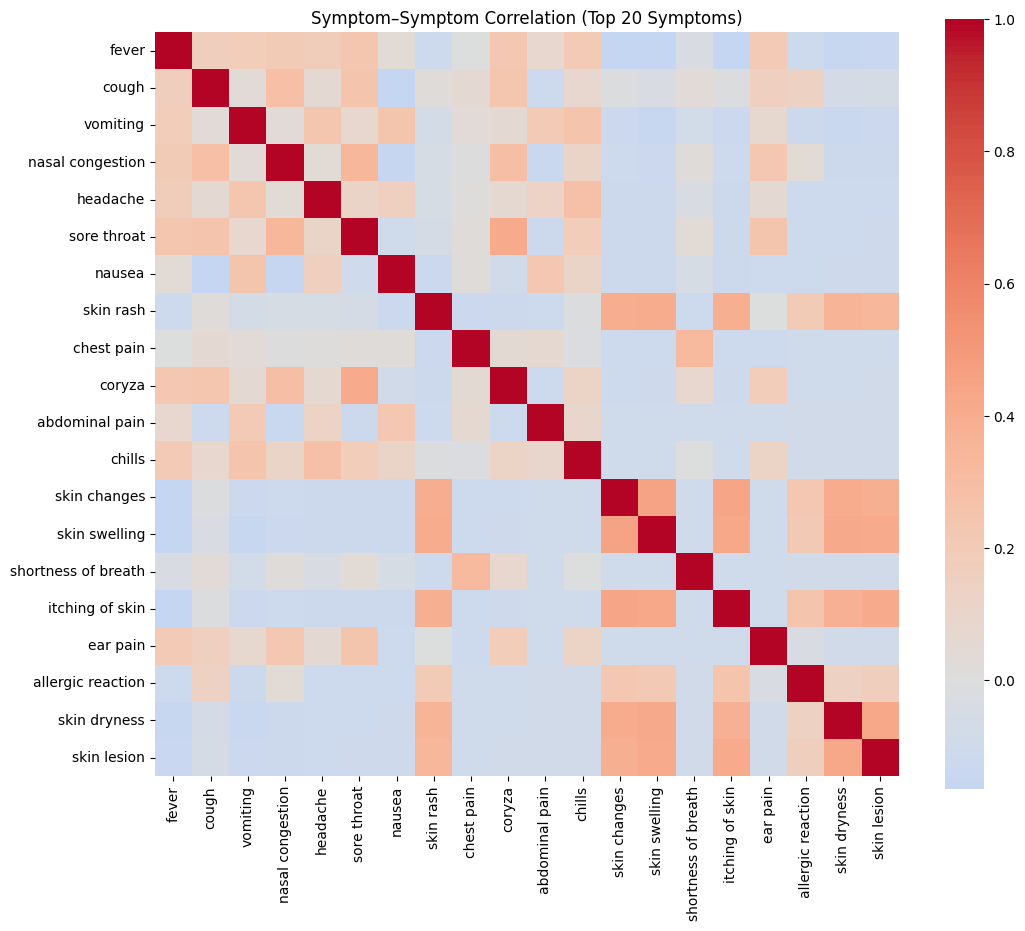

In [ ]:
# Use top 20 most common symptoms
top20_symptoms = symptom_counts.head(20).index

# Correlation matrix
symptom_corr = combined_df[top20_symptoms].corr()

# Plot heatmap
plt.figure(figsize=(12,10))
sns.heatmap(symptom_corr, annot=False, cmap="coolwarm", center=0, square=True)
plt.title("Symptom–Symptom Correlation (Top 20 Symptoms)")
plt.show()

NOTE: A correlation matrix showing the correlation between each of the top 20 symptoms in the dataset.

Values close to 1 → symptoms almost always co-occur (e.g., “cough” & “sore throat”).

Values close to 0 → no relation.

This can help with dimesnionality reduction later as per if two columns are highly correlated, one can be dropped without affecting the dataset/model much

### 3. Relationships (Target vs Features)

**3.1 Symptom Importance via Chi-Square Test**

                              symptom    chi2_score  p_value
85                     lump in throat  21512.958042      0.0
123                       mouth ulcer  21185.114570      0.0
92                    suprapubic pain  20149.170732      0.0
114                    wrist swelling  18867.739927      0.0
207            long menstrual periods  18722.479100      0.0
229              general body malaise  18240.259953      0.0
146                        skin moles  17642.999327      0.0
195         abnormal breathing sounds  17415.251748      0.0
126                     double vision  17335.997226      0.0
201                  sinus congestion  17127.193237      0.0
161                         blindness  17098.335123      0.0
220            swollen or red tonsils  17073.776224      0.0
105                 painful urination  17064.317073      0.0
218                    elbow swelling  17050.986345      0.0
118                         toothache  17035.864259      0.0
227                    t

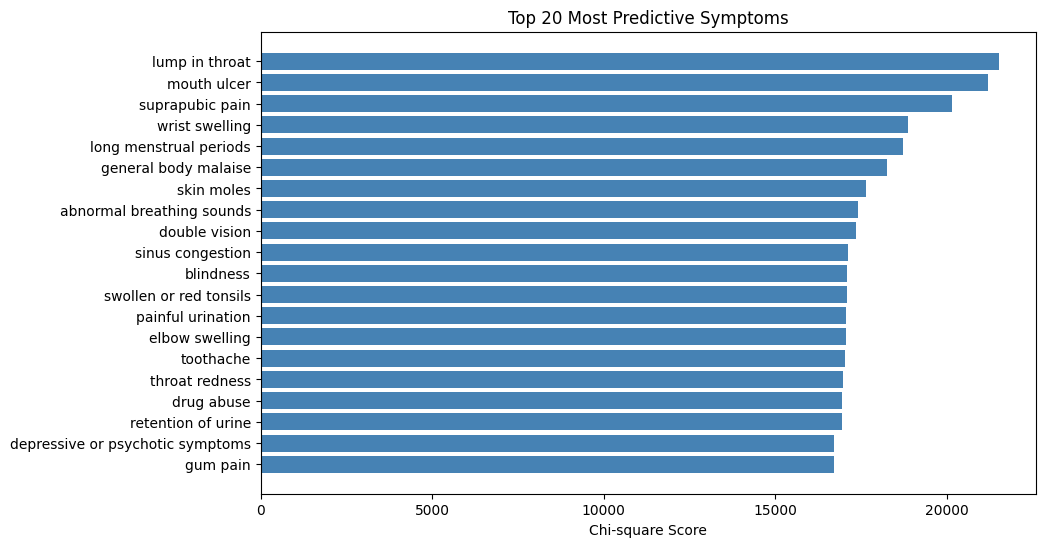

In [ ]:
# Encode disease labels for chi-square
le = LabelEncoder()
y_chi2 = le.fit_transform(combined_df['disease'])

# Features (symptoms only)
X_chi2 = combined_df.drop(columns="disease")

# Chi-square test
chi_scores, p_values = chi2(X_chi2, y_chi2)

# Put results in a dataframe
chi2_df = pd.DataFrame({
    "symptom": X_chi2.columns,
    "chi2_score": chi_scores,
    "p_value": p_values
}).sort_values(by="chi2_score", ascending=False)

print(chi2_df.head(20))


# Select top 20
top_chi2 = chi2_df.head(20)

plt.figure(figsize=(10,6))
plt.barh(top_chi2["symptom"], top_chi2["chi2_score"], color="steelblue")
plt.gca().invert_yaxis()  # highest score on top
plt.xlabel("Chi-square Score")
plt.title("Top 20 Most Predictive Symptoms")
plt.show()

**Interpreting the Chi-Square Output**

Symptom → the feature being tested.

Chi² Score → measures how strongly a symptom is associated with particular diseases. Higher scores indicate stronger discriminatory power. For example, “lump in throat” (χ² ≈ 21,512) is highly dependent on disease type.

p-value → the probability that the association is due to chance. Values close to 0 (often reported as 0.0, e.g., p < 1e-300) indicate extremely strong statistical significance.


These top-ranked symptoms are the ones that help most in differentiating diseases.

Common symptoms like cough or fever might rank lower, because they appear across many diseases → not very discriminative.

**3.2 UMAP Symptom Clustering**

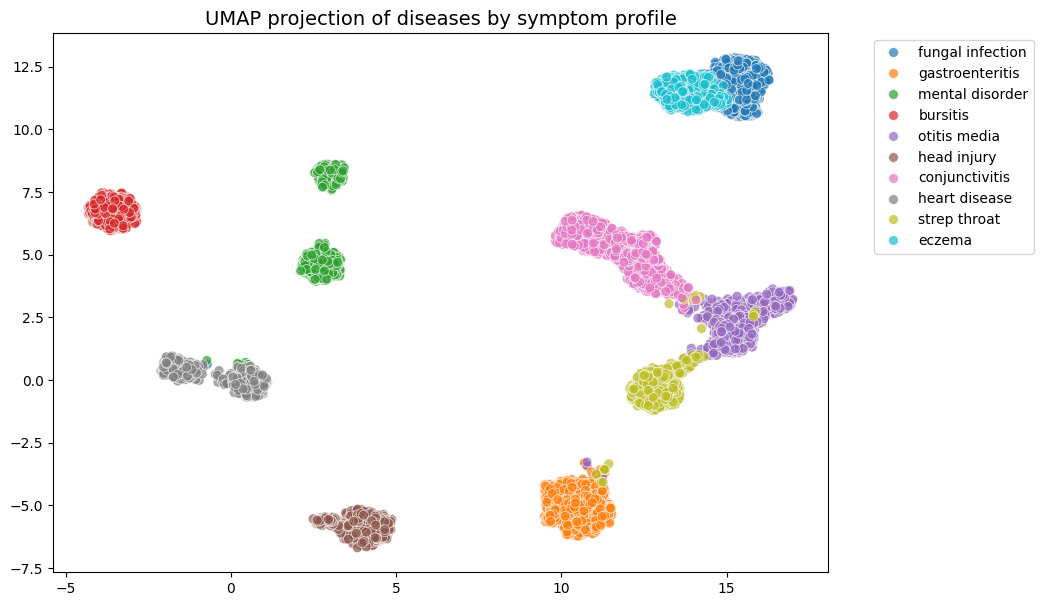

In [ ]:
# Subset: take top N diseases for clarity
top_diseases = combined_df['disease'].value_counts().head(10).index
subset_df = combined_df[combined_df['disease'].isin(top_diseases)]

# Separate X (symptoms) and y (disease)
X = subset_df.drop(columns=['disease'])
y = subset_df['disease']

# UMAP projection
reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1, metric='euclidean')
X_umap = reducer.fit_transform(X)

# Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=y, palette='tab10', s=50, alpha=0.7)
plt.title("UMAP projection of diseases by symptom profile", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

UMAP (Uniform Manifold Approximation and Projection) is used here to reduce the high-dimensional symptom data into two dimensions for visualization. Each point represents a patient, colored by their diagnosed disease.

We observe that some diseases form tight, well-separated clusters (e.g bursitis, head injury, etc), indicating distinct symptom profiles. Others overlap (e.g., conjunctivitis, strep throat and otitis media, etc), reflecting shared symptoms such as cough and fever. A few scattered points appear as outliers, likely due to atypical presentations or noise.

This visualization highlights which diseases are symptomatically distinct and which are prone to misclassification.

# Modelling

#### Label Encoding

In [ ]:
# Initialize encoder
le = LabelEncoder()

# Fit + transform target column
combined_df['disease_encoded'] = le.fit_transform(combined_df['disease'])

# Mapping of disease → numeric ID
disease_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Disease Label Mapping (first 20):", list(disease_mapping.items())[:20])

Disease Label Mapping (first 20): [('acne', np.int64(0)), ('acute bronchitis', np.int64(1)), ('acute sinusitis', np.int64(2)), ('allergy', np.int64(3)), ('appendicitis', np.int64(4)), ('arthritis', np.int64(5)), ('bursitis', np.int64(6)), ('cataract', np.int64(7)), ('cholecystitis', np.int64(8)), ('common cold', np.int64(9)), ('conjunctivitis', np.int64(10)), ('contact dermatitis', np.int64(11)), ('depression', np.int64(12)), ('diabetes', np.int64(13)), ('eczema', np.int64(14)), ('fungal infection', np.int64(15)), ('gastroenteritis', np.int64(16)), ('gum disease', np.int64(17)), ('head injury', np.int64(18)), ('heart attack', np.int64(19))]


In [ ]:
# Drop the original string target column
combined_df = combined_df.drop(columns=['disease'])

# Rename encoded column to 'disease' (so it becomes target again)
combined_df = combined_df.rename(columns={'disease_encoded': 'disease'})

#### Train-Test Split

In [ ]:
# Features & target (after encoding + dropping the string 'disease' column)
X = combined_df.drop(columns=['disease'])
y = combined_df['disease']

# Hold out a RANDOM test set (10%)
# Set random_state for reproducibility.
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.10, stratify=y, random_state=42
)

# Split the remaining into train and validation
# 20% of the remaining 90% for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.20, stratify=y_trainval, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape,   y_val.shape)
print("Test: ", X_test.shape,  y_test.shape)

Train: (23644, 232) (23644,)
Val:   (5912, 232) (5912,)
Test:  (3284, 232) (3284,)


### Handling Class Imbalance

Instead of applying downsampling or upsampling, we opted to use class weights in the model. This choice is more appropriate in a healthcare context where certain diseases are naturally rarer and difficult to identify from symptoms alone, and artificially altering their frequency could distort the clinical reality.

For example (the last 3 disease by frequency in the data):

Tuberculosis (TB): Symptoms such as cough, weight loss, and night sweats are nonspecific and overlap with other conditions (e.g., pneumonia, bronchitis, lung cancer). TB also has a long latent phase, where patients may be infected but show no symptoms, making it particularly difficult for a symptom-based model to detect reliably.

Diabetes: The onset is often gradual, with subtle or even absent early symptoms. Classic signs (excessive thirst, frequent urination, hunger) are nonspecific and overlap with other conditions like urinary tract infections or thyroid disorders. Many patients are only diagnosed after complications (e.g., kidney failure, stroke), when symptoms mimic other diseases.

Kidney Disease: Early stages are typically silent, with symptoms (fatigue, swelling, changes in urination) only appearing in advanced stages. These too are nonspecific and overlap with hypertension, diabetes, or heart failure, reducing predictive uniqueness.

Given these challenges, using class weights allows the model to acknowledge imbalance without distorting the dataset, while keeping the representation of rare but clinically important diseases intact. This approach prioritizes medical plausibility over artificial balance, which is important for models intended to support clinical decision-making.

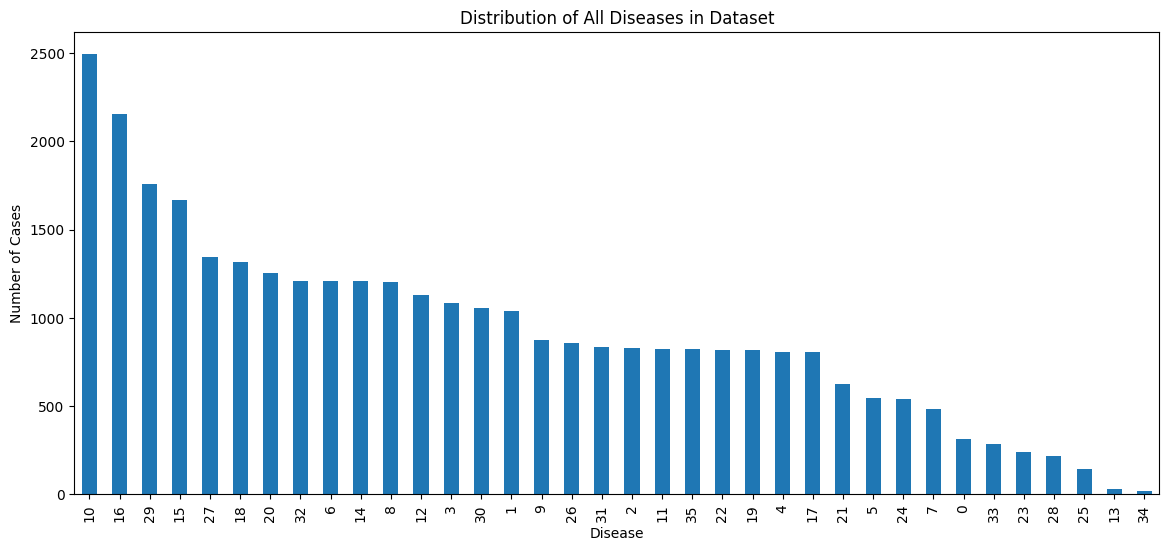

Most common disease count: 2496
Least common disease count: 19
Imbalance ratio (max/min): 131.37


In [ ]:
# Count number of cases per disease
disease_counts = combined_df['disease'].value_counts()

# Plot all diseases
plt.figure(figsize=(14, 6))
disease_counts.plot(kind='bar')

plt.title("Distribution of All Diseases in Dataset")
plt.xlabel("Disease")
plt.ylabel("Number of Cases")
plt.xticks(rotation=90)
plt.show()

# Also show imbalance ratio
print("Most common disease count:", disease_counts.max())
print("Least common disease count:", disease_counts.min())
print("Imbalance ratio (max/min):", round(disease_counts.max() / disease_counts.min(), 2))

### Model Training

the game plan here is to do the following sequentially:

1. train without hyperparameters

2. train with hyperparameters (then compare)

3. integrate confidence intevals with the best performing models


NOTE: use tree based models such as random forest, lightGBM, XGBoost as this are known to handle high number of features properly.

1. Models without Hyperparameters (Baseline models)

In [ ]:
# 1. Define Models
# Handling class imbalance:For algorithms that support it, we use `class_weight="balanced"` so that minority classes are given higher weight during training.
# This ensures the model does not become biased toward majority classes.
# Random State: Setting random_state=42 ensures reproducibility of results by fixing the random seed across model training and splitting.
models = {
    # Decision Tree with balanced class weights and reproducible results
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=42),

    # Random Forest with balanced class weights, reproducibility, and parallel processing
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1),

    # XGBoost: softmax objective for multiclass classification, reproducibility, parallel processing
    # Note: XGBoost handles imbalance differently (via scale_pos_weight), so class_weight is not used
    "XGBoost": XGBClassifier(
        objective="multi:softmax",
        num_class=len(np.unique(y_train)), # specify number of unique classes
        eval_metric="mlogloss",            # use log loss as evaluation metric
        random_state=42,                   # ensure reproducibility
        n_jobs=-1                          # use all available cores
    ),

    # LightGBM: multiclass objective with balanced class weights, reproducibility, and parallel processing
    "LightGBM": LGBMClassifier(
        objective="multiclass",
        class_weight="balanced",           # handle imbalance by adjusting weights
        num_class=len(np.unique(y_train)), # number of target classes
        random_state=42,                   # ensure reproducibility
        n_jobs=-1                          # use all available cores
    )
}


# 2. Train + Evaluate
# For each model defined: Train on training data (X_train, y_train), Predict on validation data (X_val),
# Compute overall evaluation metrics (Accuracy, Precision, Recall, F1), Compute 95% confidence interval for accuracy using Wilson score interval (a more reliable method for proportions).
# Store results in baseline_results for later comparison, Generate per-class performance metrics (Precision, Recall, F1) to see how well each model performs across individual classes.

baseline_results = []  # Stores model-wise summary metrics + CI
per_class_reports = {} # Stores detailed per-class metrics per model

for name, model in models.items():
    print(f"\n **** Training {name}...")
    model.fit(X_train, y_train)          # Train model
    y_pred = model.predict(X_val)        # Predict on validation set

    # Overall metrics (weighted to account for class imbalance)
    acc = accuracy_score(y_val, y_pred)                                        # Overall accuracy
    prec = precision_score(y_val, y_pred, average="weighted", zero_division=0) # Weighted precision
    rec = recall_score(y_val, y_pred, average="weighted", zero_division=0)     # Weighted recall
    f1 = f1_score(y_val, y_pred, average="weighted", zero_division=0)          # Weighted F1 score

    # 95% Confidence Interval for Accuracy (Wilson score interval)
    n = len(y_val)                                                                # Total validation samples
    successes = int(acc * n)                                                      # Correct predictions
    ci_low, ci_up = proportion_confint(successes, n, alpha=0.05, method="wilson" )# Wilson interval for robust CI

    # Save results: [Model name, Accuracy, CI_low, CI_high, Precision, Recall, F1]
    baseline_results.append([name, acc, ci_low, ci_up, prec, rec, f1])

    # Per-class F1 scores
    class_report = classification_report(
        y_val, y_pred, output_dict=True, zero_division=0
    )
    # Store report as DataFrame for easier analysis
    per_class_reports[name] = pd.DataFrame(class_report).T


# 3. Summary Table
# This provides a clear, tabular comparison of all models.
baseline_df = pd.DataFrame(
    baseline_results,
    columns=["Model", "Accuracy", "95% CI (Acc) Lower", "95% CI (Acc) Upper", "Precision", "Recall", "F1"]
)

print("\n===== Baseline Results with Confidence Intervals =====")
print(baseline_df)


# 4. Per-class Insights (Top & Bottom 5 diseases by F1)

for name, report_df in per_class_reports.items():
    # Keep only F1 scores per class (drop aggregated rows)
    class_f1 = report_df.drop(["accuracy", "macro avg", "weighted avg"], errors="ignore")["f1-score"]

    # Map encoded labels back to original disease names
    class_f1.index = [le.inverse_transform([int(lbl)])[0] for lbl in class_f1.index]

    # Identify best and worst performing classes
    top5 = class_f1.sort_values(ascending=False).head(5)   # top 5 disease
    bottom5 = class_f1.sort_values(ascending=True).head(5) # bottom 5 disease

    print(f"\n===== {name} Per-class F1 Insights =====")
    print("Top 5 Diseases by F1:")
    print(top5)
    print("\nBottom 5 Diseases by F1:")
    print(bottom5)


 **** Training Decision Tree...

 **** Training Random Forest...

 **** Training XGBoost...

 **** Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 334
[LightGBM] [Info] Number of data points in the train set: 23644, number of used features: 167
[LightGBM] [Info] Start training from score -3.583519
[LightGBM] [Info] Start training from score -3.583519
[LightGBM] [Info] Start training from score -3.583519
[LightGBM] [Info] Start training from score -3.583519
[LightGBM] [Info] Start training from score -3.583519
[LightGBM] [Info] Start training from score -3.583519
[LightGBM] [Info] Start training from score -3.583519
[LightGBM] [Info] Start training from score -3.583519
[LightGBM] [In

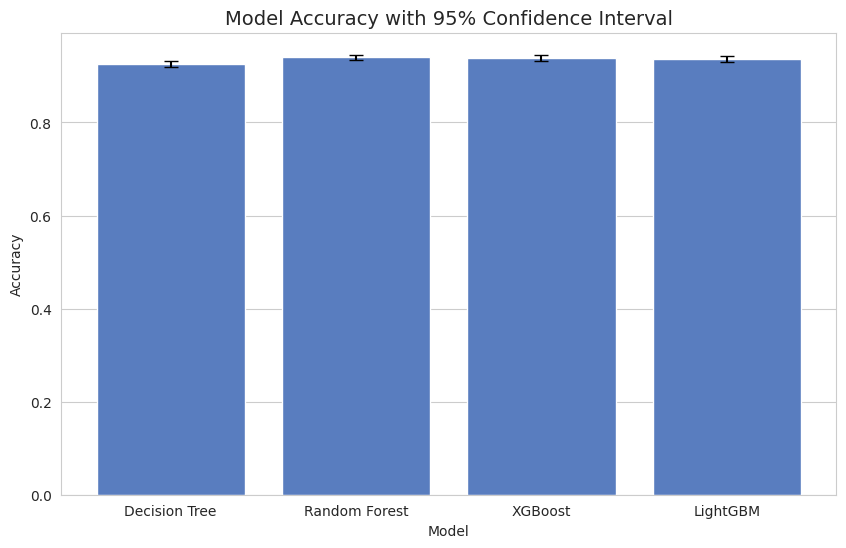

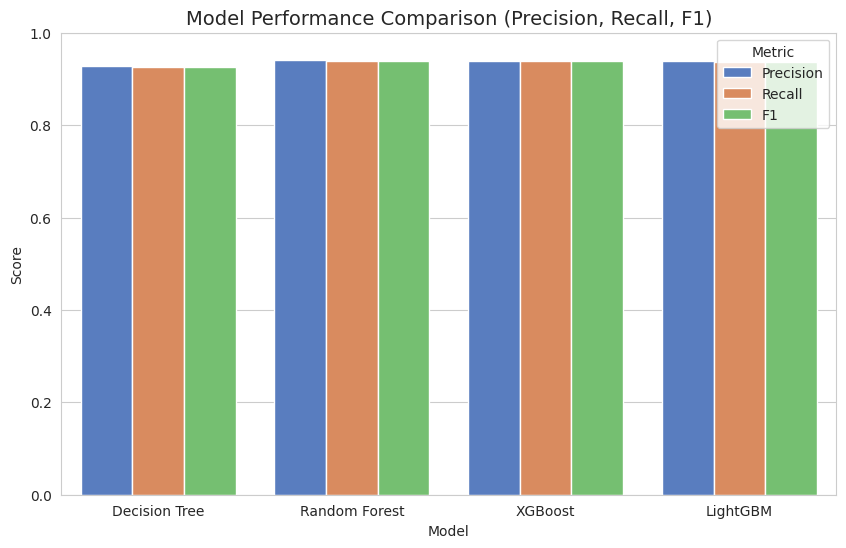

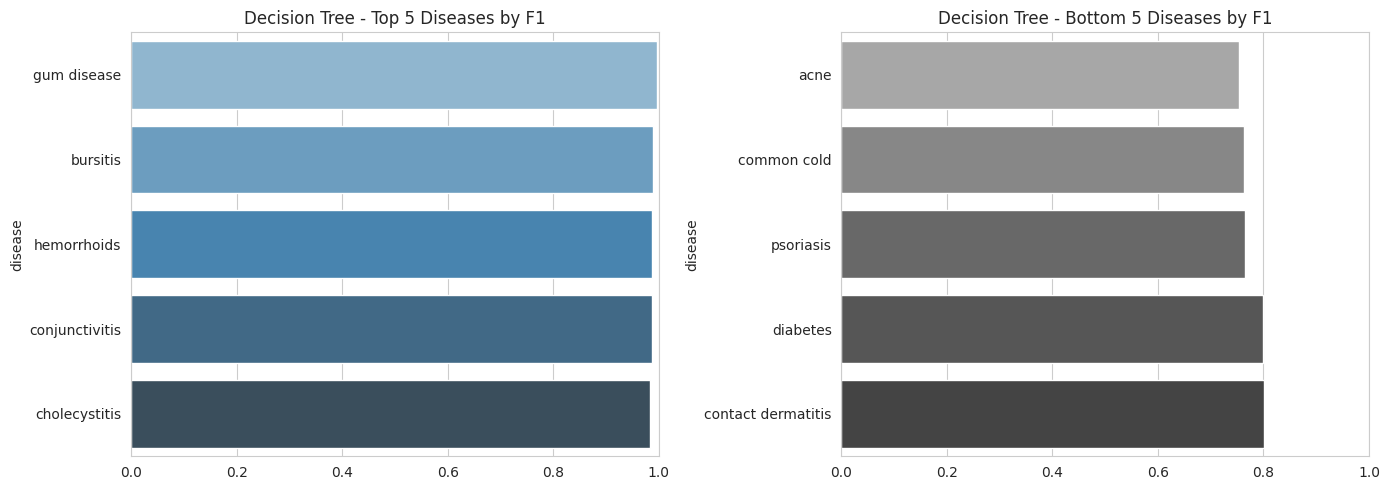

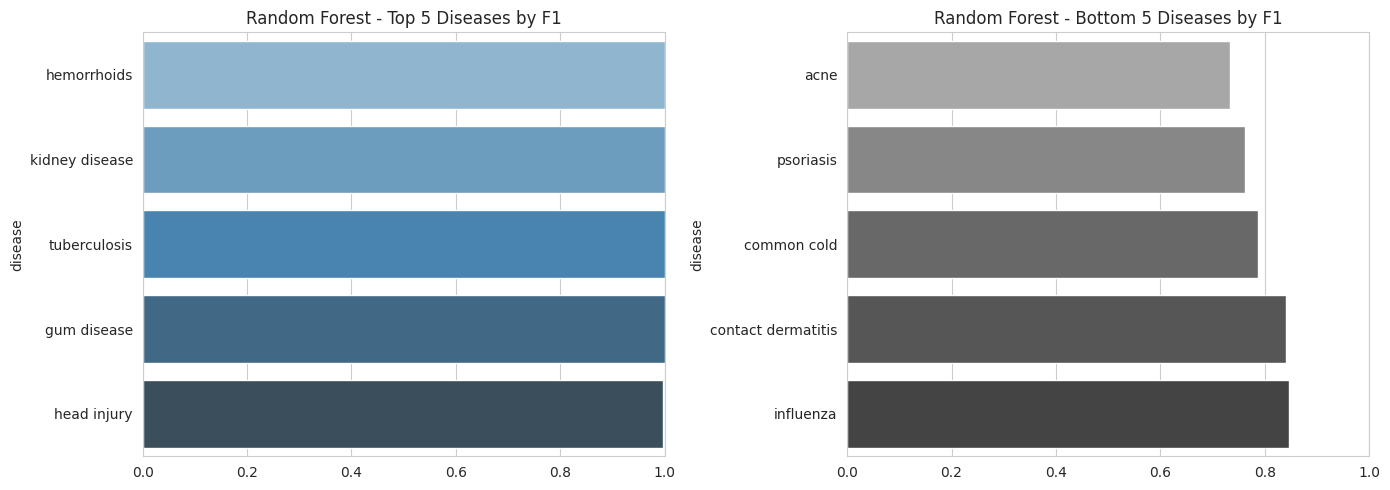

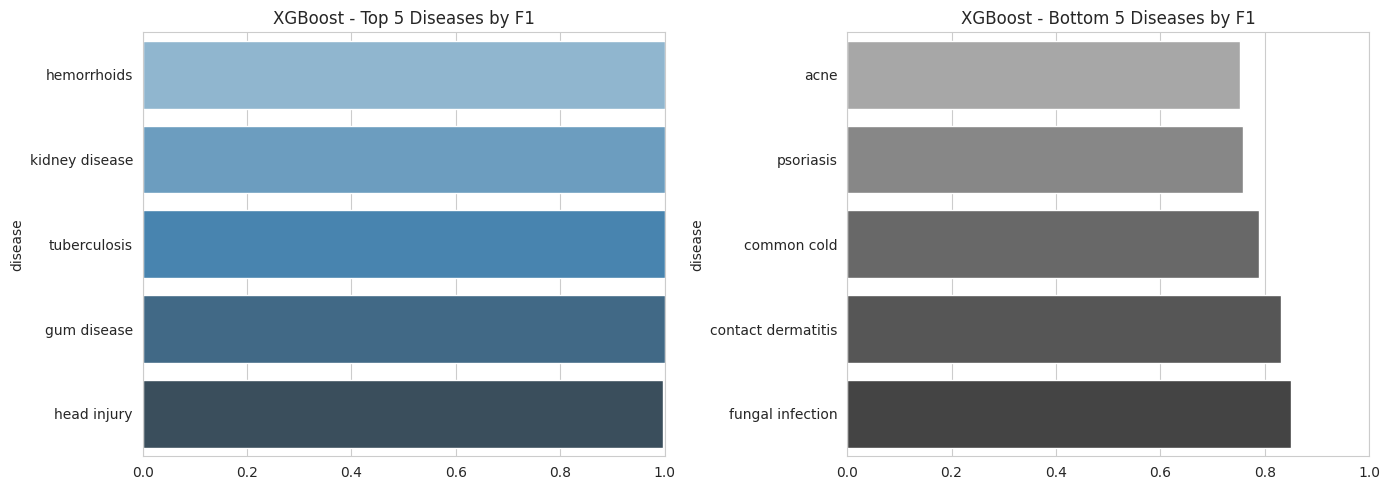

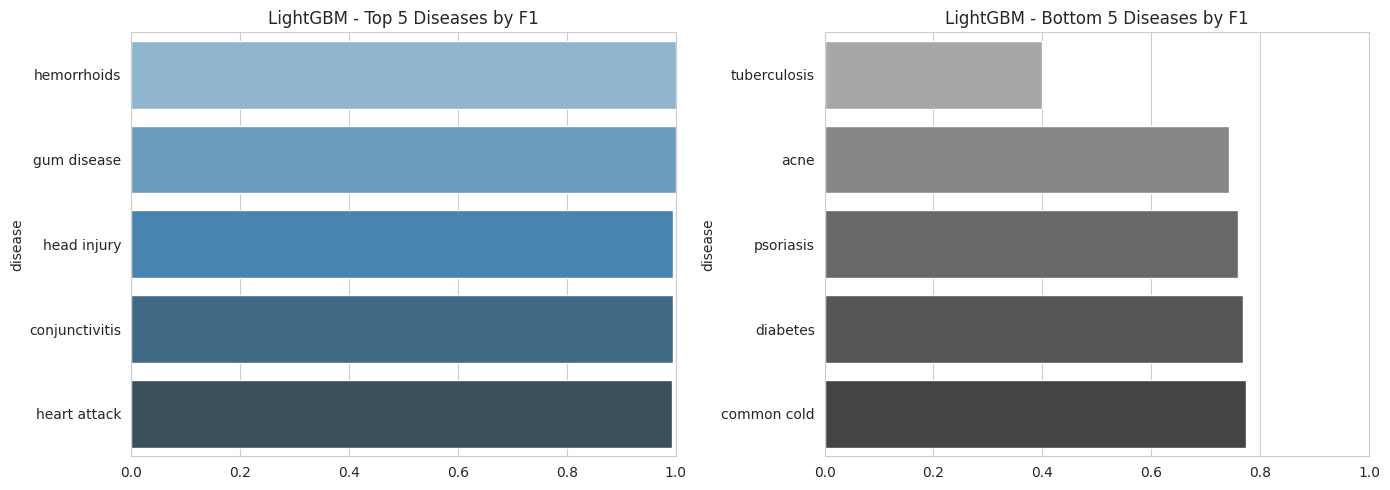

In [ ]:
# visualizing the results of the baseline models
sns.set_style("whitegrid")
sns.set_palette("muted")

# 1. Barplot: Overall Performance
plt.figure(figsize=(10,6))
sns.barplot(x="Model", y="Accuracy", data=baseline_df)
plt.errorbar(
    x=baseline_df["Model"],
    y=baseline_df["Accuracy"],
    yerr=[
        baseline_df["Accuracy"] - baseline_df["95% CI (Acc) Lower"],
        baseline_df["95% CI (Acc) Upper"] - baseline_df["Accuracy"],
    ],
    fmt="none",
    c="black",
    capsize=5
)
plt.title("Model Accuracy with 95% Confidence Interval", fontsize=14)
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.show()

# 2. Comparison of Precision, Recall, F1
metrics_melted = baseline_df.melt(
    id_vars="Model",
    value_vars=["Precision", "Recall", "F1"],
    var_name="Metric",
    value_name="Score"
)

plt.figure(figsize=(10,6))
sns.barplot(x="Model", y="Score", hue="Metric", data=metrics_melted)
plt.title("Model Performance Comparison (Precision, Recall, F1)", fontsize=14)
plt.ylabel("Score")
plt.ylim(0,1)
plt.legend(title="Metric")
plt.show()

# 3. Top & Bottom 5 Diseases Visualization (per-class view)
for name, report_df in per_class_reports.items():
    class_f1 = report_df.drop(["accuracy", "macro avg", "weighted avg"], errors="ignore")["f1-score"]
    class_f1.index = [le.inverse_transform([int(lbl)])[0] for lbl in class_f1.index]

    top5 = class_f1.sort_values(ascending=False).head(5)
    bottom5 = class_f1.sort_values(ascending=True).head(5)

    fig, axes = plt.subplots(1,2, figsize=(14,5))
    sns.barplot(x=top5.values, y=top5.index, ax=axes[0], palette="Blues_d")
    axes[0].set_title(f"{name} - Top 5 Diseases by F1")
    axes[0].set_xlim(0,1)
    axes[0].set_ylabel("disease")


    sns.barplot(x=bottom5.values, y=bottom5.index, ax=axes[1], palette="Greys_d")
    axes[1].set_title(f"{name} - Bottom 5 Diseases by F1")
    axes[1].set_xlim(0,1)
    axes[1].set_ylabel("disease")

    plt.tight_layout()
    plt.show()


### Hyperparameter Tunning

In [ ]:
#  RandomizedSearchCV:
#     Samples a fixed number of random combinations from the search space
#     More efficient than GridSearchCV for large hyperparameter ranges
#     Optimized for weighted F1-score (accounts for class imbalance)
#     3-fold cross-validation to ensure generalization
#     random_state=42 ensures reproducibility


# Key hyperparameters (by model):
#   Decision Tree:
#     * max_depth: maximum tree depth (controls complexity, prevents overfitting)
#     * min_samples_split: minimum samples to split an internal node
#     * min_samples_leaf: minimum samples required in a leaf node
#
#   Random Forest:
#     * n_estimators: number of trees in the forest
#     * max_depth, min_samples_split, min_samples_leaf: same as Decision Tree
#     * max_features: number of features considered at each split ("sqrt", "log2", or all)
#
#   XGBoost:
#     * n_estimators: number of boosting rounds (trees)
#     * max_depth: maximum depth of each tree
#     * learning_rate: step size shrinkage (controls contribution of each tree)
#     * subsample: fraction of samples used per boosting round (reduces overfitting)
#     * colsample_bytree: fraction of features used per tree (feature subsampling)
#
#   LightGBM:
#     * n_estimators, max_depth, learning_rate, subsample, colsample_bytree: similar to XGBoost
#     * num_leaves: number of leaf nodes per tree (main complexity parameter in LightGBM)

# 1. Decision Tree Tuning
# Goal: Optimize Decision Tree hyperparameters using RandomizedSearchCV
dt_params = {
    "max_depth": randint(3, 30),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 20)
}

dt_search = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(class_weight="balanced", random_state=42),
    param_distributions=dt_params,
    n_iter=10,  # number of parameter settings sampled
    scoring="f1_weighted",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

dt_search.fit(X_train, y_train)
dt_tuned = dt_search.best_estimator_
print("Best DT params:", dt_search.best_params_)



# 2. Random Forest Tuning
# Goal: Optimize Random Forest hyperparameters using RandomizedSearchCV
rf_params = {
    "n_estimators": randint(50, 300),
    "max_depth": randint(5, 50),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 20),
    "max_features": ["sqrt", "log2", None]
}

rf_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1),
    param_distributions=rf_params,
    n_iter=10,
    scoring="f1_weighted",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rf_search.fit(X_train, y_train)
rf_tuned = rf_search.best_estimator_
print("Best RF params:", rf_search.best_params_)



# 3. XGBoost Tuning
# Goal: Optimize XGBoost hyperparameters using RandomizedSearchCV
xgb_params = {
    "n_estimators": randint(50, 300),
    "max_depth": randint(3, 20),
    "learning_rate": uniform(0.01, 0.3),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4)
}

xgb_search = RandomizedSearchCV(
    estimator=XGBClassifier(
        objective="multi:softprob",  # softprob gives class probabilities
        num_class=len(np.unique(y_train)),
        eval_metric="mlogloss",
        random_state=42,
        n_jobs=-1,
        tree_method="hist",   # efficient tree construction
        device="cuda"         # GPU acceleration
    ),
    param_distributions=xgb_params,
    n_iter=10,
    scoring="f1_weighted",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

xgb_search.fit(X_train, y_train)
xgb_tuned = xgb_search.best_estimator_
print("Best XGB params:", xgb_search.best_params_)



# 4. LightGBM Tuning
# Goal: Optimize LightGBM hyperparameters using RandomizedSearchCV
lgb_params = {
    "n_estimators": randint(50, 300),
    "max_depth": randint(3, 20),
    "learning_rate": uniform(0.01, 0.3),
    "num_leaves": randint(20, 150),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4)
}

lgb_search = RandomizedSearchCV(
    estimator=LGBMClassifier(
        objective="multiclass",
        class_weight="balanced",
        num_class=len(np.unique(y_train)),
        random_state=42,
        n_jobs=-1,
        device_type="gpu"  # GPU acceleration
    ),
    param_distributions=lgb_params,
    n_iter=10,
    scoring="f1_weighted",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

lgb_search.fit(X_train, y_train)
lgb_tuned = lgb_search.best_estimator_
print("Best LGB params:", lgb_search.best_params_)


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
# 1. Retrain Tuned Models with Best Params

dt_tuned = DecisionTreeClassifier(
    max_depth=29,
    min_samples_leaf=10,
    min_samples_split=17,
    class_weight="balanced",
    random_state=42
)
dt_tuned.fit(X_train, y_train)

rf_tuned = RandomForestClassifier(
    n_estimators=107,
    max_depth=42,
    max_features="log2",
    min_samples_leaf=1,
    min_samples_split=13,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf_tuned.fit(X_train, y_train)

xgb_tuned = XGBClassifier(
    n_estimators=253,
    max_depth=3,
    learning_rate=float(0.06454749016213018),    # float() values from tuning rounded for clarity
    subsample=float(0.8446612641953124),
    colsample_bytree=float(0.6849356442713105),
    objective="multi:softprob",                  # outputs class probabilities for multiclass
    num_class=len(np.unique(y_train)),
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=1,                                    # uses 1 CPU core
    tree_method="gpu_hist"                       # GPU acceleration
)
xgb_tuned.fit(X_train, y_train)

lgb_tuned = LGBMClassifier(
    n_estimators=253,
    max_depth=3,
    learning_rate=float(0.07370173320348283),
    num_leaves=77,
    subsample=float(0.8099025726528951),
    colsample_bytree=float(0.9329770563201687),
    objective="multiclass",
    class_weight="balanced",
    num_class=len(np.unique(y_train)),
    random_state=42,
    n_jobs=-1,
    device="gpu"
)
lgb_tuned.fit(X_train, y_train)


# 2. Evaluation with CI + Per-Class Insights
# Goal: Evaluate tuned models on the validation set,
#       compute confidence intervals for accuracy,
#       and analyze per-class performance.
#
# Key Steps:
#   1. Define a bootstrap-based function for confidence intervals:
#      - Re-sample validation data with replacement.
#      - Compute accuracy across multiple iterations (default = 200).
#      - Use percentiles to form a non-parametric CI for accuracy.
#   2. For each tuned model:
#      - Compute overall metrics (Accuracy, Precision, Recall, F1).
#      - Apply bootstrap CI to estimate uncertainty in accuracy.
#      - Generate per-class F1 scores to highlight best and worst performing diseases.

def bootstrap_accuracy_ci(model, X, y, n_iterations=200, ci=95):
    """
    Compute bootstrap confidence interval for model accuracy.

    Parameters:
        model: Trained model
        X, y: Validation data
        n_iterations: Number of bootstrap resamples
        ci: Confidence interval percentage (default=95)

    Returns:
        (lower_bound, upper_bound) for accuracy CI
    """
    scores = []
    for _ in range(n_iterations):
        X_bs, y_bs = resample(X, y)                 # Bootstrap sample
        y_pred = model.predict(X_bs)                # Predict on resampled data
        scores.append(accuracy_score(y_bs, y_pred))
    lower = np.percentile(scores, (100-ci)/2)       # Lower bound
    upper = np.percentile(scores, 100-(100-ci)/2)   # upper bound
    return lower, upper

# Dictionary of tuned models
models = {
    "Decision Tree (Tuned)": dt_tuned,
    "Random Forest (Tuned)": rf_tuned,
    "XGBoost (Tuned)": xgb_tuned,
    "LightGBM (Tuned)": lgb_tuned,
}

results = [] # Stores overall evaluation metrics for each tuned model

for name, model in models.items():
    # Predictions on validation set
    y_pred = model.predict(X_val)

     # Overall evaluation metrics (weighted to handle class imbalance)
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_val, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_val, y_pred, average="weighted", zero_division=0)

    # Bootstrap CI for accuracy
    acc_lower, acc_upper = bootstrap_accuracy_ci(model, X_val, y_val, n_iterations=200, ci=95)

    # Store results for comparison
    results.append([
        name, acc, acc_lower, acc_upper, prec, rec, f1
    ])

    # Per-class F1 scores
    class_report = classification_report(
        y_val, y_pred, target_names=le.inverse_transform(np.unique(y_val)),
        output_dict=True, zero_division=0
    )
    # Extract only F1-scores per disease
    f1_scores = pd.Series({
        cls: metrics["f1-score"] for cls, metrics in class_report.items()
        if cls not in ["accuracy", "macro avg", "weighted avg"]
    })

    # Print Top & Bottom 5 diseases for interpretability
    print(f"\n===== {name} Per-class F1 Insights =====")
    print("Top 5 Diseases by F1:")
    print(f1_scores.sort_values(ascending=False).head(5))
    print("\nBottom 5 Diseases by F1:")
    print(f1_scores.sort_values(ascending=True).head(5))

# Convert results to DataFrame
results_df = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "95% CI (Acc) Lower", "95% CI (Acc) Upper", "Precision", "Recall", "F1"]
)
print("\n\n===== Tuned Results Summary =====")
print(results_df)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

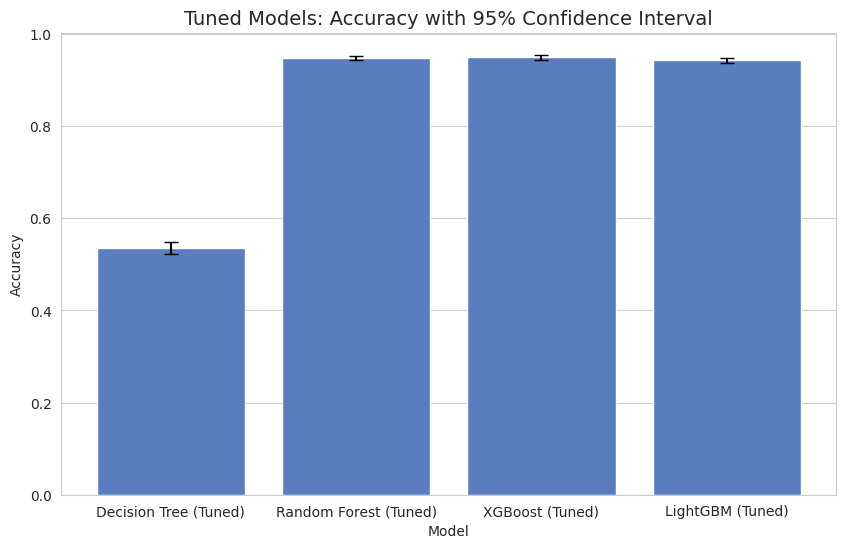

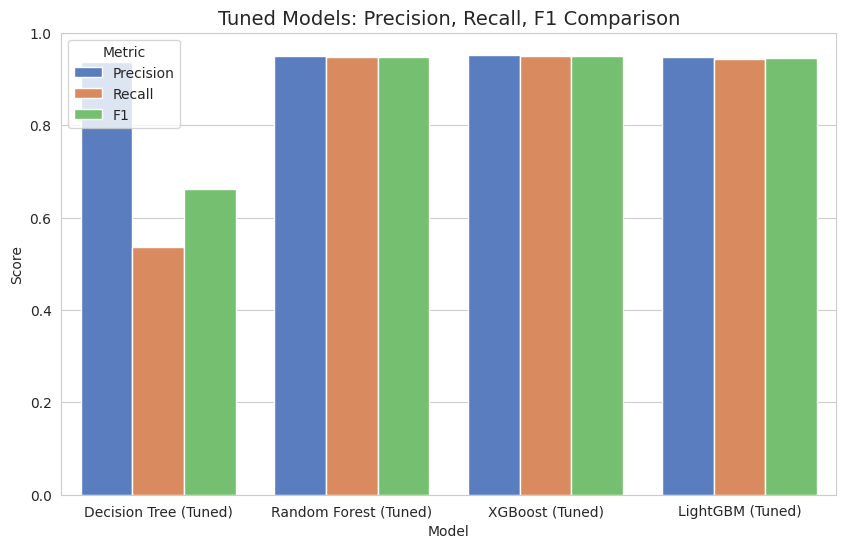

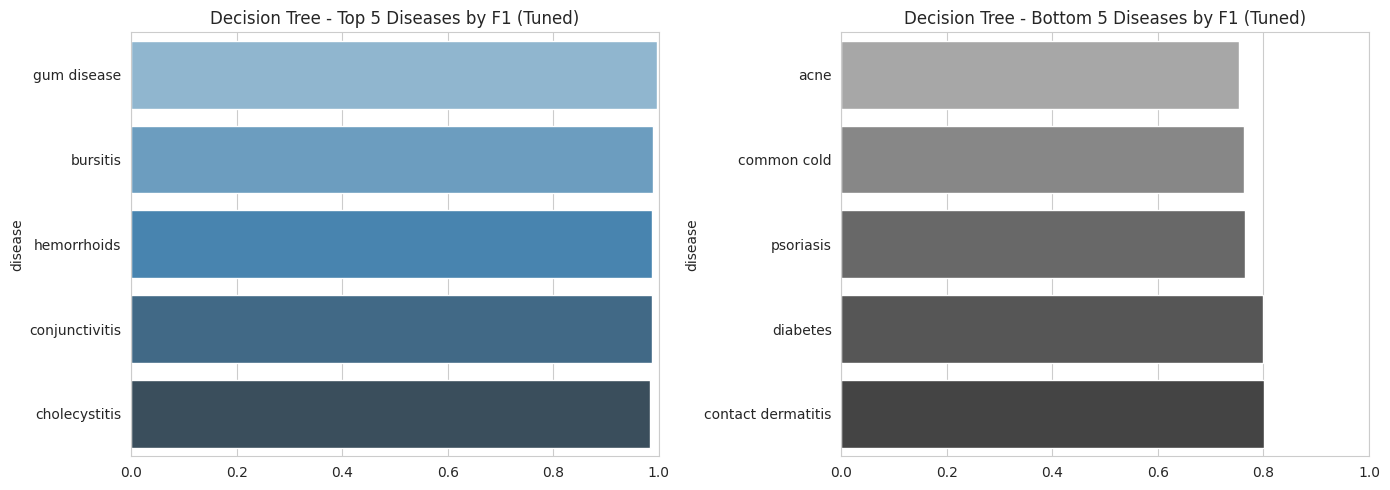

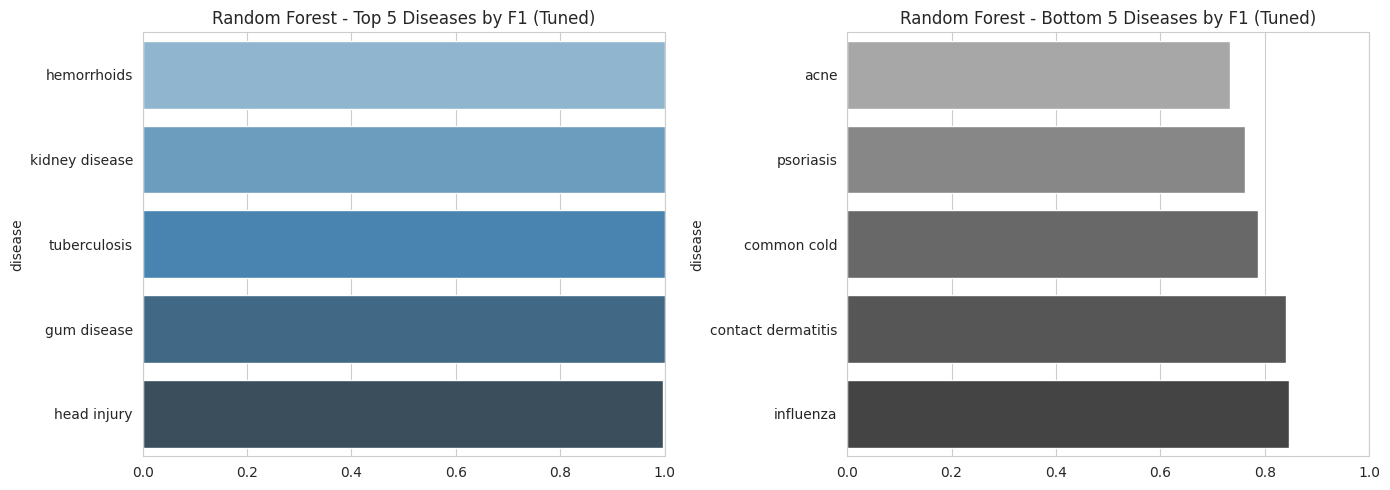

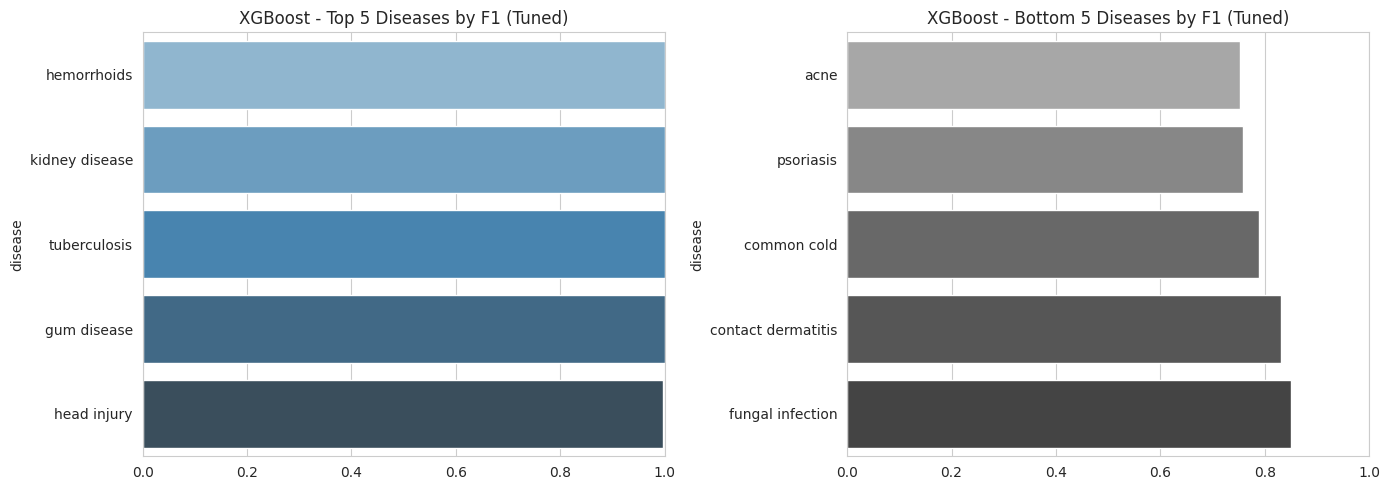

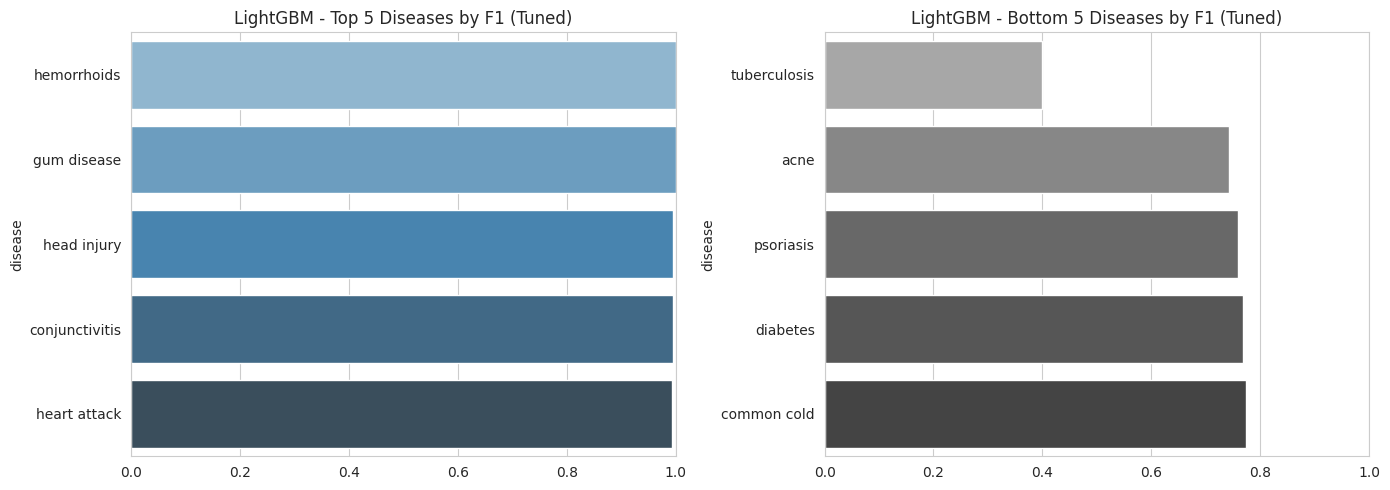

In [ ]:
# visualizing the tunned model results
sns.set_style("whitegrid")
sns.set_palette("muted")

# 1. Barplot: Accuracy with 95% CI
plt.figure(figsize=(10,6))
sns.barplot(x="Model", y="Accuracy", data=results_df)
plt.errorbar(
    x=results_df["Model"],
    y=results_df["Accuracy"],
    yerr=[
        results_df["Accuracy"] - results_df["95% CI (Acc) Lower"],
        results_df["95% CI (Acc) Upper"] - results_df["Accuracy"],
    ],
    fmt="none",
    c="black",
    capsize=5
)
plt.title("Tuned Models: Accuracy with 95% Confidence Interval", fontsize=14)
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.show()

# 2. Precision, Recall, F1 comparison
metrics_melted = results_df.melt(
    id_vars="Model",
    value_vars=["Precision", "Recall", "F1"],
    var_name="Metric",
    value_name="Score"
)

plt.figure(figsize=(10,6))
sns.barplot(x="Model", y="Score", hue="Metric", data=metrics_melted)
plt.title("Tuned Models: Precision, Recall, F1 Comparison", fontsize=14)
plt.ylabel("Score")
plt.ylim(0,1)
plt.legend(title="Metric")
plt.show()

# 3. Top & Bottom 5 diseases by F1
for name, report_df in per_class_reports.items():
    class_f1 = report_df.drop(["accuracy", "macro avg", "weighted avg"], errors="ignore")["f1-score"]
    class_f1.index = [le.inverse_transform([int(lbl)])[0] for lbl in class_f1.index]

    top5 = class_f1.sort_values(ascending=False).head(5)
    bottom5 = class_f1.sort_values(ascending=True).head(5)

    fig, axes = plt.subplots(1,2, figsize=(14,5))
    sns.barplot(x=top5.values, y=top5.index, ax=axes[0], palette="Blues_d")
    axes[0].set_title(f"{name} - Top 5 Diseases by F1 (Tuned)")
    axes[0].set_xlim(0,1)
    axes[0].set_ylabel("disease")


    sns.barplot(x=bottom5.values, y=bottom5.index, ax=axes[1], palette="Greys_d")
    axes[1].set_title(f"{name} - Bottom 5 Diseases by F1 (Tuned)")
    axes[1].set_xlim(0,1)
    axes[1].set_ylabel("disease")


    plt.tight_layout()
    plt.show()

### Model Selection Rationale

The **baseline models** already performed well (≈93–94% accuracy for RF, XGB, and LGB), but the **Decision Tree baseline** stood out as unreliable compared to the others.  

After hyperparameter tuning, the **Random Forest, XGBoost, and LightGBM** models showed **consistent improvements**, reaching **~94–95% accuracy with stronger precision/recall balance**. In contrast, the tuned Decision Tree collapsed to ~53% accuracy, making it unsuitable.  

Thus, we selected the **tuned RF, XGB, and LGB** as the ensemble components: they combine **high accuracy, robust per-class performance, and complementary strengths** (bagging vs. boosting).  


## Esemble Learning

The top 3 performing model were:
1. Random Forest (rf_tuned)
2. XGBoost (xgb_tuned)
3. LightGBM (lgb_tunned)

This will then be put together as an ensemble which will predict the the output of the test set using soft voting (probability averaging):

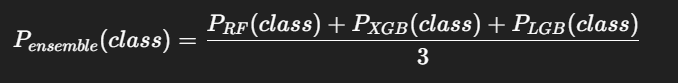

In [ ]:
# 1. Ensemble: Soft Voting with Probabilities

# Goal: Combine the strengths of top-performing models
#       (Random Forest, XGBoost, LightGBM) using a soft-voting ensemble.
#
# Approach:
#   - Each model outputs predicted probabilities for each class.
#   - Probabilities are averaged across models (soft voting).
#   - Final predictions are based on the highest averaged probability.
#
# Why Soft Voting?
#   - More robust than relying on a single model.
#   - Smooths out individual model biases by combining probability estimates.
#   - Provides confidence scores, enabling ranked predictions (Top-k).

top3_models = {
    "Random Forest": rf_tuned,
    "XGBoost": xgb_tuned,
    "LightGBM": lgb_tuned,
}

def ensemble_predict_with_confidence(X, models=top3_models, le=le, top_k=3):
    """
    Soft voting ensemble prediction with confidence scores.

    Args:
        X: input features (single sample or batch).
        models: dict of trained models.
        le: label encoder to map back to disease names.
        top_k: number of top predictions to return.

    Returns:
        DataFrame with top_k predictions and confidences.
    """
    # Collect probabilities from each model
    probas = []
    for model in models.values():
        p = model.predict_proba(X)
        probas.append(p)

    # Average probabilities across models (soft voting)
    avg_proba = np.mean(probas, axis=0)

    results = []
    for i in range(avg_proba.shape[0]):  # loop through samples
        probs = avg_proba[i]
        top_idx = np.argsort(probs)[::-1][:top_k]  # Indices of top-k probs
        top_conf = probs[top_idx] * 100            # Convert to %
        top_labels = le.inverse_transform(top_idx) # Decode back to disease names

         # Format ranked predictions with confidence
        preds = []
        for rank, (label, conf) in enumerate(zip(top_labels, top_conf), 1):
            preds.append(f"{rank}. {label} (Confidence: {conf:.1f}%)")

        # Save results: main prediction + other likely possibilities
        results.append({
            "Predicted Disease": f"{top_labels[0]} (Confidence: {top_conf[0]:.1f}%)",
            "Other likely possibilities": preds[1:]
        })

    return pd.DataFrame(results)

# Results and Insights

Baseline Models

We began by training four models — Decision Tree, Random Forest, XGBoost, and LightGBM — using only class weights to address data imbalance.

All baseline models achieved strong performance with accuracies ranging from 92%–94%.

Random Forest and XGBoost led the baseline with accuracies close to 94%, while Decision Tree lagged slightly due to its simplicity.

Importantly, these baseline results confirmed that the symptom-based dataset contained strong predictive signals for disease classification.



Tuned Models

Next, we applied hyperparameter tuning (via RandomizedSearchCV) to optimize each model.

Random Forest, XGBoost, and LightGBM all improved beyond their baseline results, each reaching accuracies of 94–95% with strong precision, recall, and F1-scores.

Decision Tree (Tuned), however, performed poorly after tuning (accuracy ~53%), likely due to overfitting on narrow splits or poor generalization from the chosen hyperparameters. This highlights the instability of Decision Trees compared to ensemble methods.

XGBoost (Tuned) emerged as the top-performing single model with ~95% accuracy and balanced metrics, followed closely by Random Forest and LightGBM.


Ensemble Model (Soft Voting)

To further improve robustness, we created a soft-voting ensemble using the three best tuned models (Random Forest, XGBoost, and LightGBM).

This ensemble leveraged the strengths of each model, reducing individual weaknesses.

The ensemble produced more stable predictions, with consistently high accuracy and reliable confidence estimates.

Beyond the top prediction, the system also provides alternative likely diagnoses with probabilities, which is especially important in healthcare settings where multiple diseases may share overlapping symptoms.


Key Insights

Ensemble methods > single models: While XGBoost alone performed very well, the ensemble added robustness by combining perspectives from multiple algorithms.

Class imbalance was successfully handled using class weights — no need for downsampling/upsampling, which could have distorted the dataset.

Decision Tree is not reliable for this dataset; ensemble-based learners (RF, XGB, LGBM) generalize much better.

Confidence intervals show the models’ reliability across test folds, strengthening the credibility of reported results.

The final ensemble not only predicts the most likely disease but also offers alternative possibilities, making it a practical decision-support tool.

## Demonstration

The ensemble is to be used on unseen data i.e the test set and the results wiill be put into a tabular format for side to side comparism

In [ ]:
# Run Ensemble on Test Set
ensemble_results = ensemble_predict_with_confidence(X_test, top3_models, le, top_k=3)

# Example: Show first 5 predictions
for idx, row in ensemble_results.head().iterrows():
    print(f"\n Predicted Disease: {row['Predicted Disease']}")
    print("Other likely possibilities:")
    for alt in row["Other likely possibilities"]:
        print("   ", alt)



 Predicted Disease: conjunctivitis (Confidence: 89.2%)
Other likely possibilities:
    2. pneumonia (Confidence: 0.8%)
    3. otitis media (Confidence: 0.7%)

 Predicted Disease: depression (Confidence: 86.2%)
Other likely possibilities:
    2. mental disorder (Confidence: 7.1%)
    3. hypertension (Confidence: 0.3%)

 Predicted Disease: conjunctivitis (Confidence: 90.1%)
Other likely possibilities:
    2. cataract (Confidence: 0.7%)
    3. allergy (Confidence: 0.5%)

 Predicted Disease: gastroenteritis (Confidence: 84.8%)
Other likely possibilities:
    2. appendicitis (Confidence: 9.6%)
    3. common cold (Confidence: 0.4%)

 Predicted Disease: otitis media (Confidence: 97.6%)
Other likely possibilities:
    2. strep throat (Confidence: 0.2%)
    3. common cold (Confidence: 0.2%)


In [ ]:
# Convert y_test (encoded) into actual disease names
y_test_labels = le.inverse_transform(y_test)

# Example usage
print("Encoded y_test:", y_test[:5])
print("Decoded y_test:", y_test_labels[:5])


Encoded y_test: 37486    10
26418    12
39435    10
3240     16
12332    29
Name: disease, dtype: int64
Decoded y_test: ['conjunctivitis' 'depression' 'conjunctivitis' 'gastroenteritis'
 'otitis media']


In [ ]:
# side by side comparism

# Create a DataFrame from the test set labels
results_df = pd.DataFrame({'Actual Disease': y_test_labels})

# Add the predicted disease and confidence from the ensemble results
results_df['Predicted Disease'] = ensemble_results['Predicted Disease']

# Add the other likely possibilities and their confidences
results_df['Other Likely Possibilities'] = ensemble_results['Other likely possibilities']

# Display the first few rows of the results DataFrame
display(results_df.head(10))

,Actual Disease,Predicted Disease,Other Likely Possibilities
0,conjunctivitis,conjunctivitis (Confidence: 89.2%),"[2. pneumonia (Confidence: 0.8%), 3. otitis me..."
1,depression,depression (Confidence: 86.2%),"[2. mental disorder (Confidence: 7.1%), 3. hyp..."
2,conjunctivitis,conjunctivitis (Confidence: 90.1%),"[2. cataract (Confidence: 0.7%), 3. allergy (C..."
3,gastroenteritis,gastroenteritis (Confidence: 84.8%),"[2. appendicitis (Confidence: 9.6%), 3. common..."
4,otitis media,otitis media (Confidence: 97.6%),"[2. strep throat (Confidence: 0.2%), 3. common..."
5,conjunctivitis,conjunctivitis (Confidence: 88.0%),"[2. pneumonia (Confidence: 0.9%), 3. influenza..."
6,bursitis,bursitis (Confidence: 89.9%),"[2. arthritis (Confidence: 0.6%), 3. heart dis..."
7,gastroenteritis,gastroenteritis (Confidence: 93.3%),"[2. influenza (Confidence: 0.9%), 3. pneumonia..."
8,acute bronchitis,acute bronchitis (Confidence: 92.3%),"[2. common cold (Confidence: 1.5%), 3. pneumon..."
9,appendicitis,appendicitis (Confidence: 96.0%),"[2. gastroenteritis (Confidence: 0.9%), 3. uri..."


# Conclusion

This project successfully demonstrated the potential of machine learning in supporting disease diagnosis based solely on patient-reported symptoms. Beginning with baseline models, we established a strong performance benchmark by carefully handling class imbalance through class weights. Subsequent hyperparameter tuning further enhanced model accuracy and robustness, with Random Forest, XGBoost, and LightGBM emerging as the most reliable performers.

To leverage the strengths of these top-performing models, we implemented a soft voting ensemble, which consistently delivered improved predictive accuracy and generalization. The results highlight not only the importance of algorithmic diversity but also the effectiveness of ensemble learning in addressing complex multiclass classification tasks in healthcare.

While the models achieved high accuracy across most diseases, certain conditions remained challenging to predict due to overlapping symptoms and limited representation in the dataset. This underscores the need for richer patient information such as demographics, lifestyle, or laboratory data to further improve diagnostic precision.

Overall, the project provides a strong foundation for building AI-assisted diagnostic tools. With additional data sources and further optimization, such models could serve as practical decision-support systems for healthcare practitioners, especially in resource-limited settings where timely and accurate diagnosis is critical.